In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mpl

import numpy as np

from qutip import *
from tqdm import tqdm
import math

#from src.functions import *
from qutip import parallel_map

import time
import inspect
import collections

from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import proplot as pplot

In [3]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

In [4]:
# The input energy values are in units of the TMSM frequency omega
def theta(Dr_inp, chi_inp):
    wg = np.sqrt((2*chi_inp)**2 + (2*Dr_inp)**2)
    theta = np.arcsin(2*chi_inp/wg)
    return theta

In [5]:
# The input energy values are in units of the TMSM frequency omega
def r1g(Ds_inp, Dr_inp, chi_inp):
    wg = np.sqrt((2*chi_inp)**2 + (2*Dr_inp)**2)
    r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
    return r1g

In [6]:
# The input energy values are in units of the TMSM frequency omega
def r2g(Ds_inp, Dr_inp, chi_inp):
    wg = np.sqrt((2*chi_inp)**2 + (2*Dr_inp)**2)
    r2g = np.arctanh(2*Ds_inp/(1 + wg/2))/2
    return r2g

In [7]:
def Lx(Ds_inp, Dr_inp, chi_inp):
    th = theta(Dr_inp, chi_inp)
    r1 = r1g(Ds_inp, Dr_inp, chi_inp)
    r2 = r2g(Ds_inp, Dr_inp, chi_inp)
    Lx = np.sin(th)*(np.sinh(r1)**2-np.sinh(r2)**2)/2
    return Lx

In [8]:
def Lz(Ds_inp, Dr_inp, chi_inp):
    th = theta(Dr_inp, chi_inp)
    r1 = r1g(Ds_inp, Dr_inp, chi_inp)
    r2 = r2g(Ds_inp, Dr_inp, chi_inp)
    Lz = np.cos(th)*(np.sinh(r1)**2-np.sinh(r2)**2)/2
    return Lz

In [9]:
def varLx(Ds_inp, Dr_inp, chi_inp):
    th = theta(Dr_inp, chi_inp)
    r1 = r1g(Ds_inp, Dr_inp, chi_inp)
    r2 = r2g(Ds_inp, Dr_inp, chi_inp)
    
    varLx = np.sin(th)**2*(np.cosh(r1)**2*np.sinh(r1)**2 + np.cosh(r2)**2*np.sinh(r2)**2+np.sinh(r1)**4+np.sinh(r2)**4)/4 + np.cos(th)**2*(np.cosh(r1)*np.sinh(r1)*np.cosh(r2)*np.sinh(r2) + np.sinh(r1)**2*np.sinh(r2)**2)/2 + (np.sinh(r1)**2 + np.sinh(r2)**2)/4
    return varLx

In [10]:
def varLy(Ds_inp, Dr_inp, chi_inp):
    th = theta(Dr_inp, chi_inp)
    r1 = r1g(Ds_inp, Dr_inp, chi_inp)
    r2 = r2g(Ds_inp, Dr_inp, chi_inp)
    
    varLy = (np.cosh(r1)*np.sinh(r2)-np.cosh(r2)*np.sinh(r1))**2/4
    return varLy

In [11]:
def varLz(Ds_inp, Dr_inp, chi_inp):
    th = theta(Dr_inp, chi_inp)
    r1 = r1g(Ds_inp, Dr_inp, chi_inp)
    r2 = r2g(Ds_inp, Dr_inp, chi_inp)
    
    varLz = np.cos(th)**2*((np.cosh(r1)*np.sinh(r1)-np.cosh(r2)*np.sinh(r2))**2 + np.sinh(r1)**4 + np.sinh(r2)**4)/4 + np.sin(th)**2*np.sinh(r1)**2*np.sinh(r2)**2/2 + np.cosh(r1)*np.sinh(r1)*np.cosh(r2)*np.sinh(r2)/2 + (np.sinh(r1)**2 + np.sinh(r2)**2)/4
    return varLz

In [12]:
def ellX(Ds_inp, Dr_inp, chi_inp):
    VarX = varLx(Ds_inp, Dr_inp, chi_inp)
    z = Lz(Ds_inp, Dr_inp, chi_inp)
    sx = 2*VarX/z
    return sx

In [13]:
def ellY(Ds_inp, Dr_inp, chi_inp):
    VarY = varLy(Ds_inp, Dr_inp, chi_inp)
    z = Lz(Ds_inp, Dr_inp, chi_inp)
    sy = 2*VarY/z
    return sy

In [14]:
def Heisenberg(Ds_inp, Dr_inp, chi_inp):
    heisenberg = ellX(Ds_inp, Dr_inp, chi_inp)*ellY(Ds_inp, Dr_inp, chi_inp)
    return heisenberg

In [15]:
def ps_squeezing(Ds_inp, Dr_inp, chi_inp):
    #xi =- np.log(varLy(Ds_inp, Dr_inp, chi_inp)/varLx(Ds_inp, Dr_inp, chi_inp))/4
    xi = -1/2 * np.log(ellY(Ds_inp, Dr_inp, chi_inp))
    return xi

In [16]:
def Lx_mn(Ds_inp, Dr_inp, m_inp, n_inp):
    r1 = r1g(Ds_inp, Dr_inp, 0)
    r2 = r2g(Ds_inp, Dr_inp, 0)
    Lx = 1/2*(m_inp*(np.cosh(r1)**2+np.sinh(r1)**2)+np.sinh(r1)**2) - 1/2*(n_inp*(np.cosh(r2)**2+np.sinh(r2)**2)+np.sinh(r2)**2)
    return Lx

In [17]:
def varLy_mn(Ds_inp, Dr_inp, m_inp, n_inp):
    r1 = r1g(Ds_inp, Dr_inp, 0)
    r2 = r2g(Ds_inp, Dr_inp, 0)
    
    varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2
    return varLy

In [18]:
def varLz_mn(Ds_inp, Dr_inp, m_inp, n_inp):
    r1 = r1g(Ds_inp, Dr_inp, 0)
    r2 = r2g(Ds_inp, Dr_inp, 0)
    
    varLz = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)+np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)+np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)+np.sinh(r2)*np.cosh(r1))**2
    return varLz

In [19]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

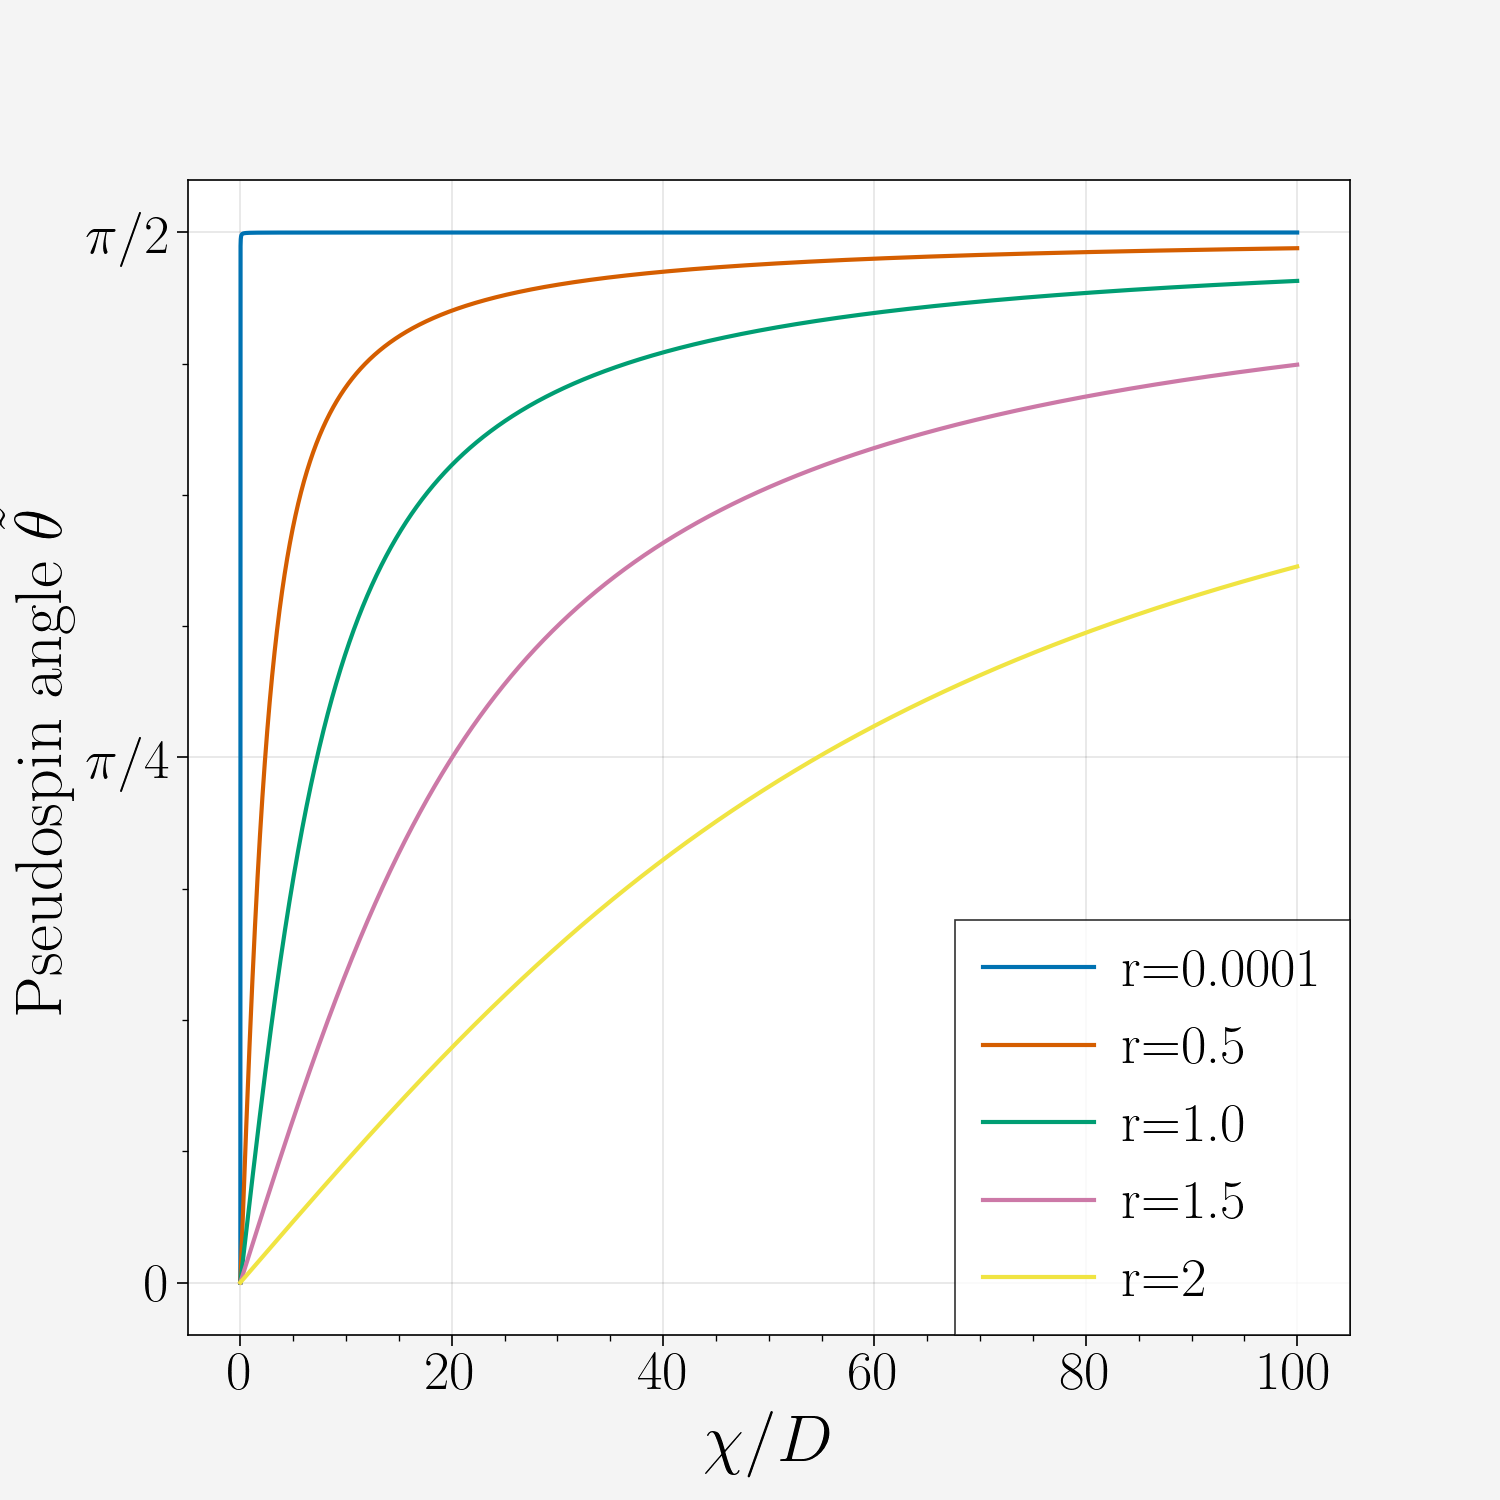

In [15]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

# x is D/chi
x = np.arange(0,100,0.01)
r_arr = [0.0001, 0.5,1.0,1.5,2]

for r in r_arr:
    #th = np.arcsin(1/np.sqrt(1 + 4*x**(2)*np.sinh(2*r)**2))
    th = np.arcsin(x/np.sqrt(x**2 + 4*np.sinh(2*r)**2))
    ax.plot(x, th, label = '{}{}'.format('r=',r))#wd_label[i])
ax.set_xlabel(r'$\chi/D$', fontsize = 24)
ax.set_ylabel(r'Pseudospin angle $\tilde{\theta}$', fontsize = 24)
ax.tick_params(labelsize = 20) 
ax.set_yticks([0,np.pi/4,np.pi/2])
ax.set_yticklabels( ['0', '$\pi/4$', '$\pi/2$'])
#ax.set_title('Contrast', fontsize = 2)
ax.legend(fontsize=20)
plt.show()

Note: 
- The angle only depends on the ratio chi/D
- Larger chi/D de-hybridizes the alpha and beta modes

## r1

C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2


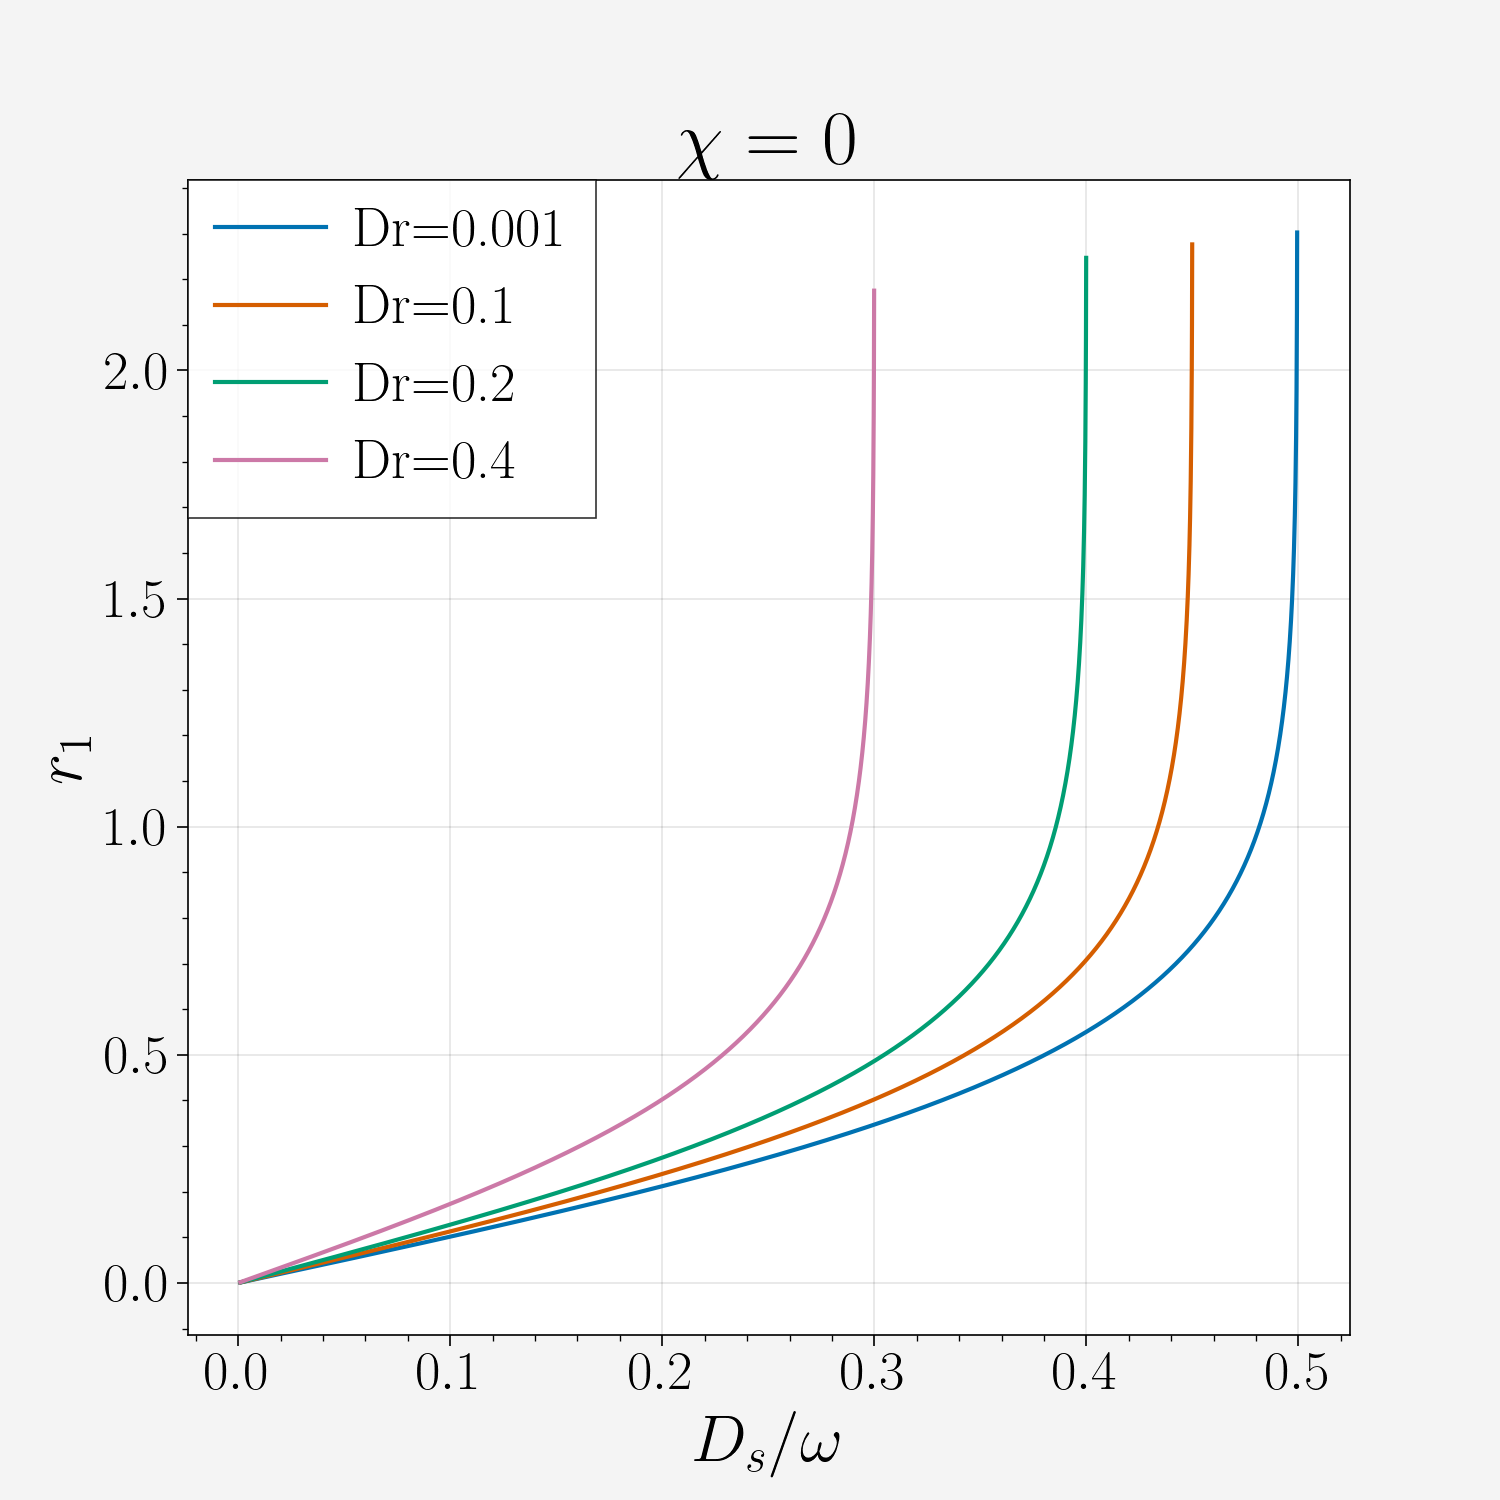

In [41]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr_arr = [0.001, 0.1,0.2,0.4]
#r_arr = [0.5,1.0,1.5]
chi = 0

for Dr in Dr_arr:
    x = np.arange(0.001,0.5,0.0001)
    r1 = r1g(x, Dr, chi)
    #r_new = r2_new(r, x, chi)
    ax.plot(x, r1, label = '{}{}'.format('Dr=',Dr))#wd_label[i])
    #ax.plot(x, r_new, label = '{}{}'.format('rn=',r))#wd_label[i])
ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'$r_1$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2


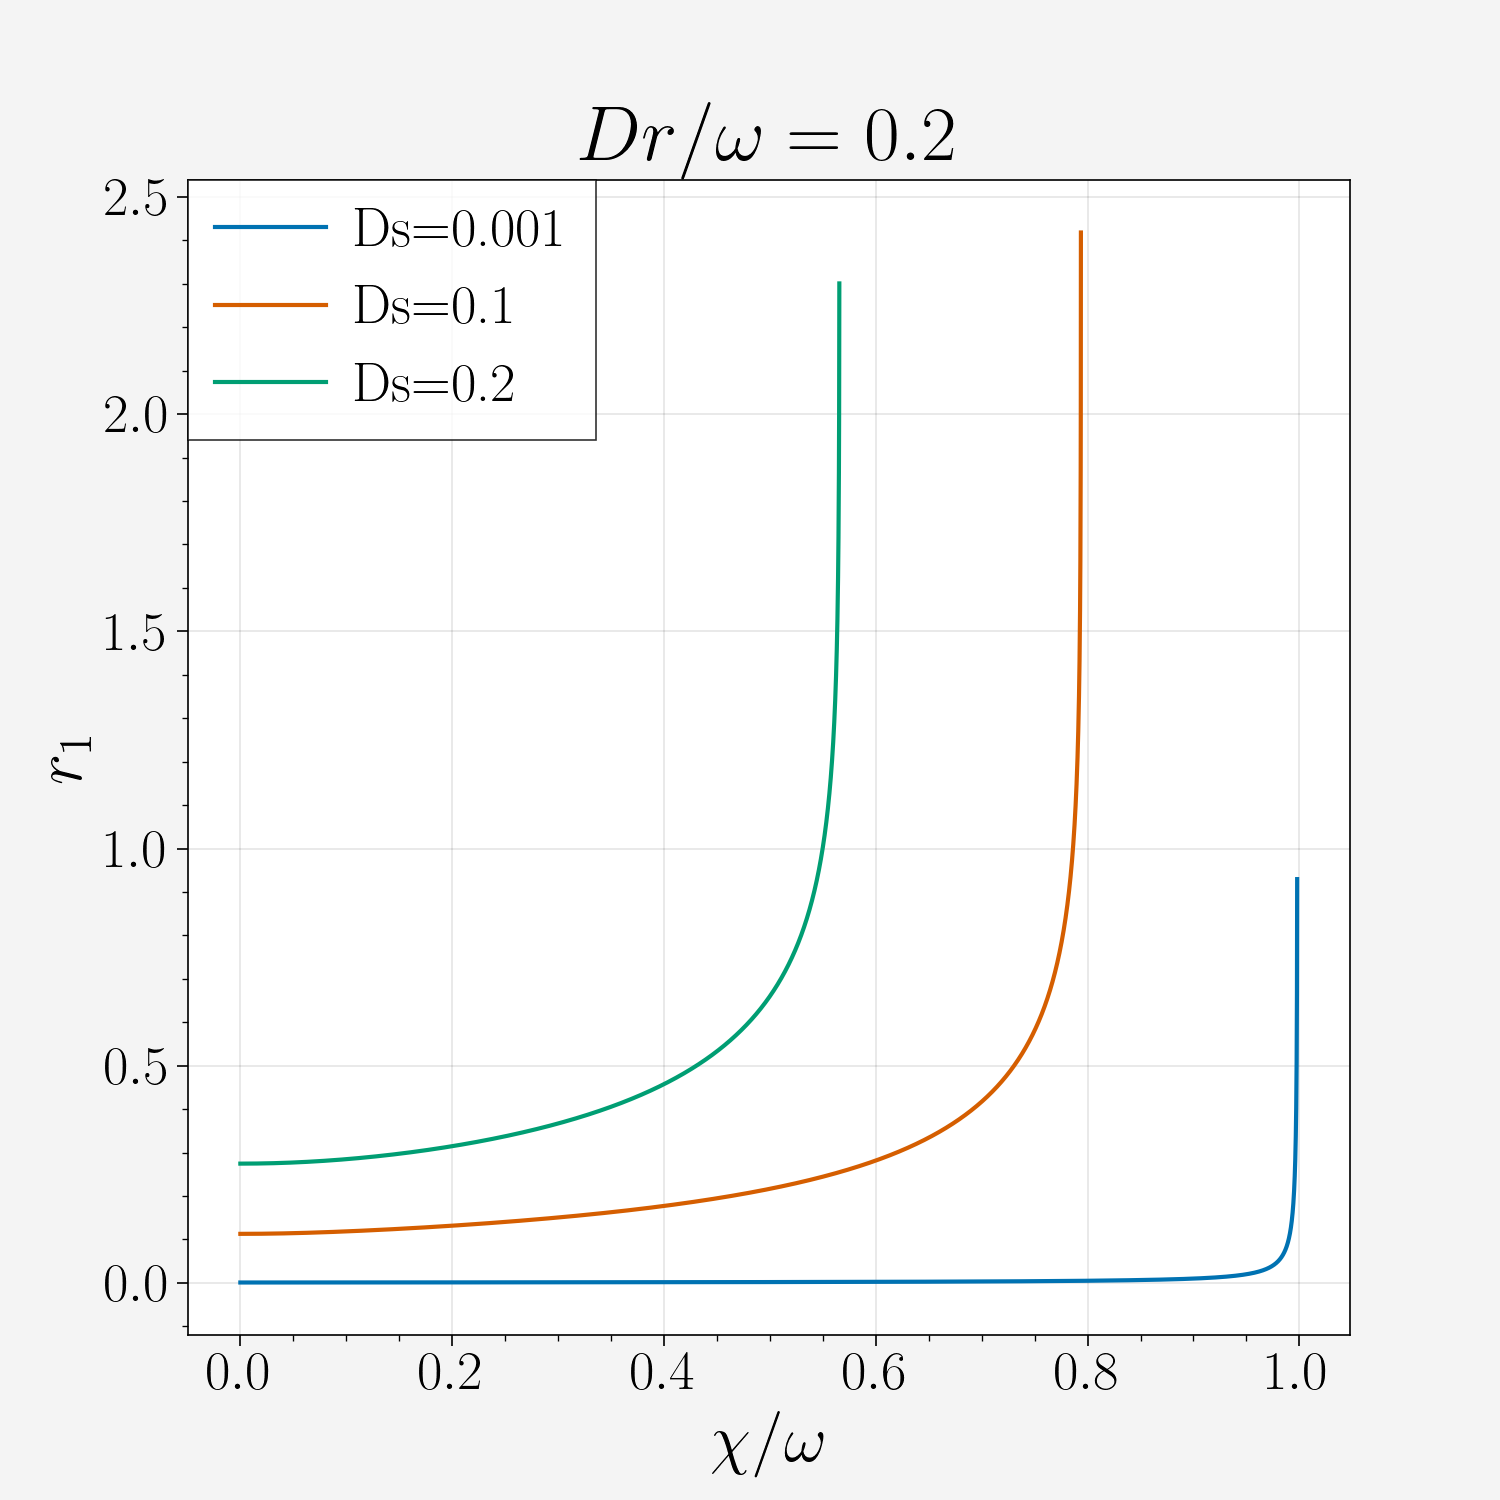

In [45]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Ds_arr = [0.001, 0.1,0.2]
Dr = 0.2

for Ds in Ds_arr:
    y = np.arange(0,1,0.0001)
    r1 = r1g(Ds, Ds, y)
    ax.plot(y, r1, label = '{}{}'.format('Ds=',Ds))#wd_label[i])
ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.set_ylabel(r'$r_1$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$Dr/\omega = 0.2$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

Notes:
- $r_1$ is only defined for $D/\omega < \exp(-2r)/2$ or $D/\omega > \exp(2r)/2$ and $\chi/\omega < \sqrt{1 - 4D\cosh(2r)/\omega+ (D/\omega)^2}$

## r2

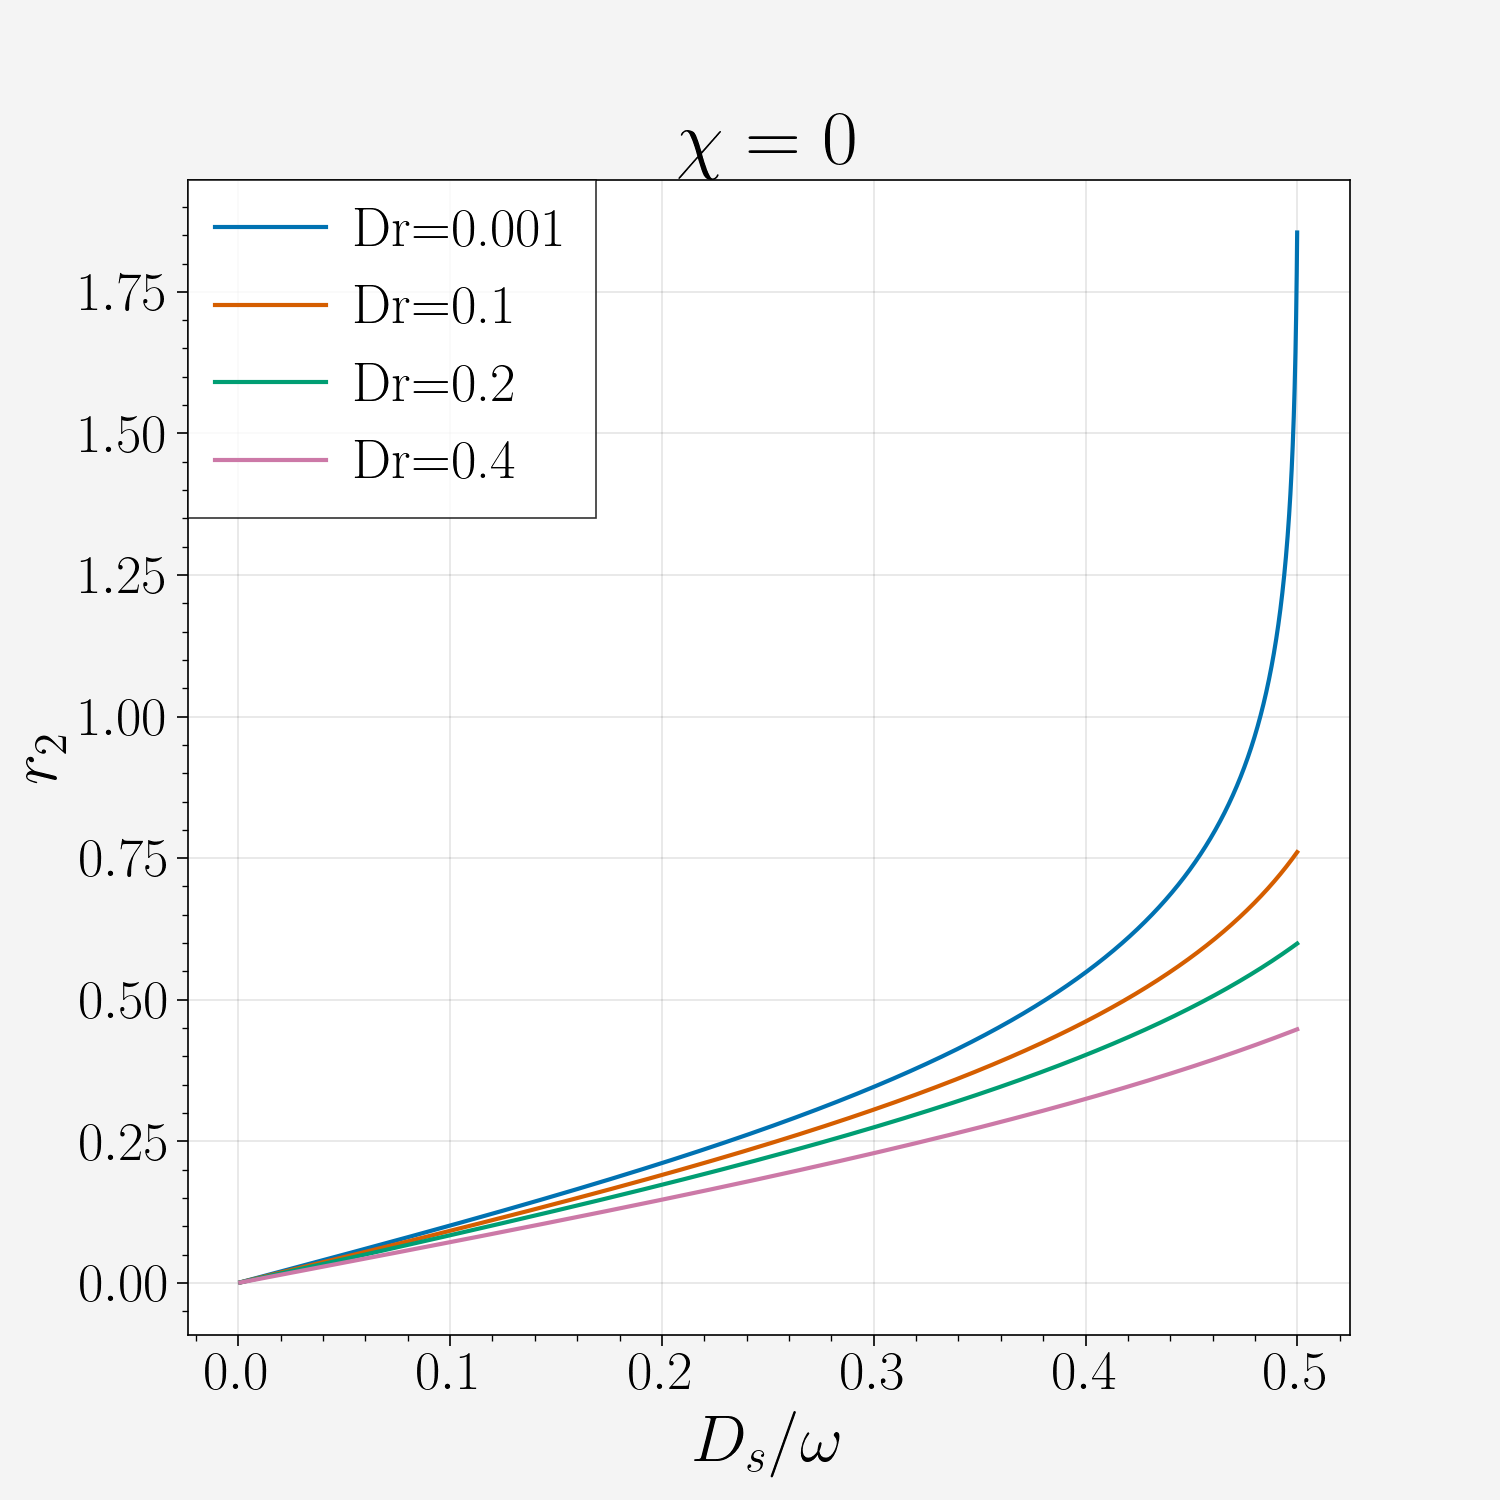

In [46]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr_arr = [0.001, 0.1,0.2,0.4]
chi = 0

for Dr in Dr_arr:
    x = np.arange(0.001,0.5,0.0001)
    r2 = r2g(x, Dr, chi)
    #r_new = r2_new(r, x, chi)
    ax.plot(x, r2, label = '{}{}'.format('Dr=',Dr))#wd_label[i])
    #ax.plot(x, r_new, label = '{}{}'.format('rn=',r))#wd_label[i])
ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'$r_2$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

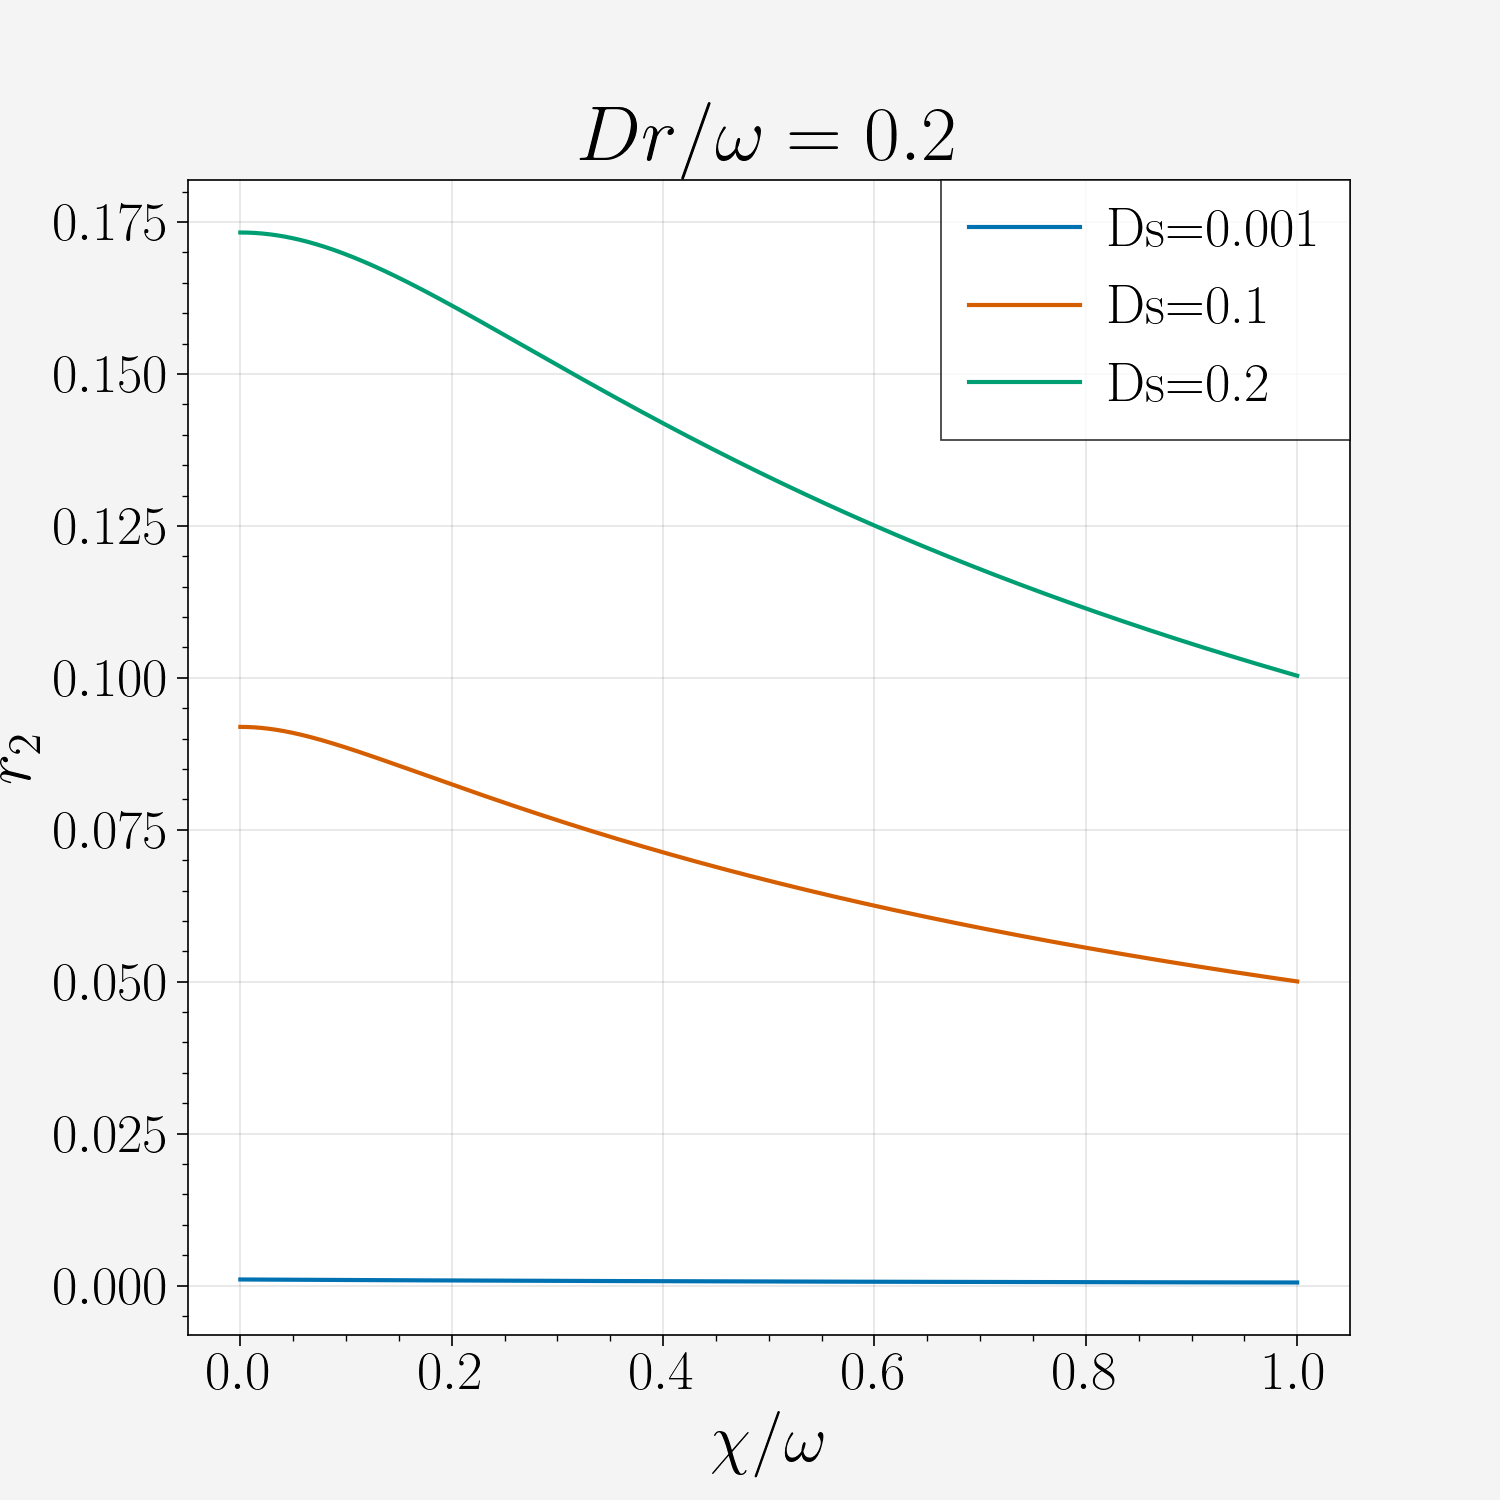

In [47]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Ds_arr = [0.001, 0.1,0.2]
Dr = 0.2

for Ds in Ds_arr:
    y = np.arange(0,1,0.0001)
    r2 = r2g(Ds, Ds, y)
    ax.plot(y, r2, label = '{}{}'.format('Ds=',Ds))#wd_label[i])
ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.set_ylabel(r'$r_2$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$Dr/\omega = 0.2$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

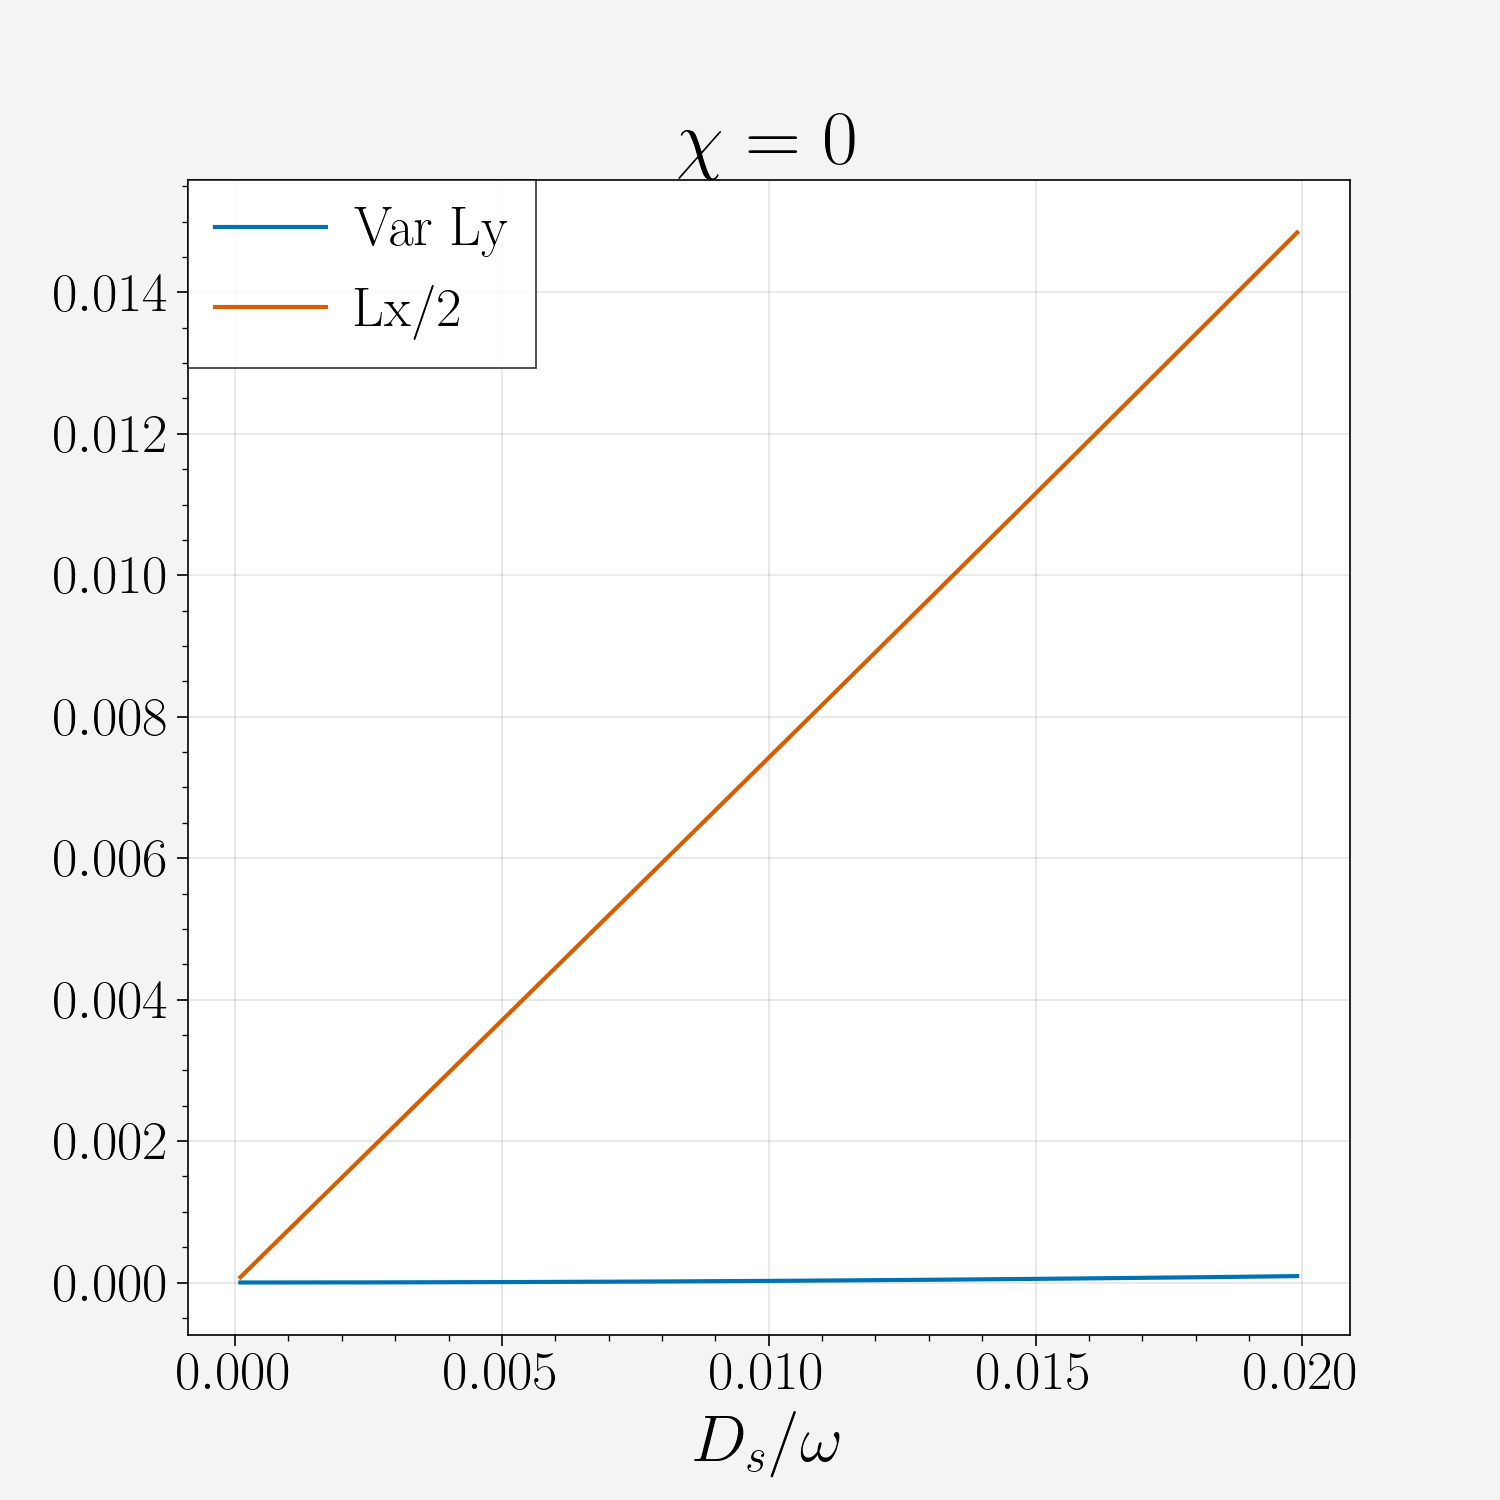

In [54]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
chi = 0

x = np.arange(0.0001,0.02,0.0001)

VarY = varLy(x, Dr, chi)
z = Lz(Dr, x, chi)
ax.plot(x, VarY, label = 'Var Ly')#wd_label[i])
ax.plot(x, z/2, label = r'Lx/2')#wd_label[i])
ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

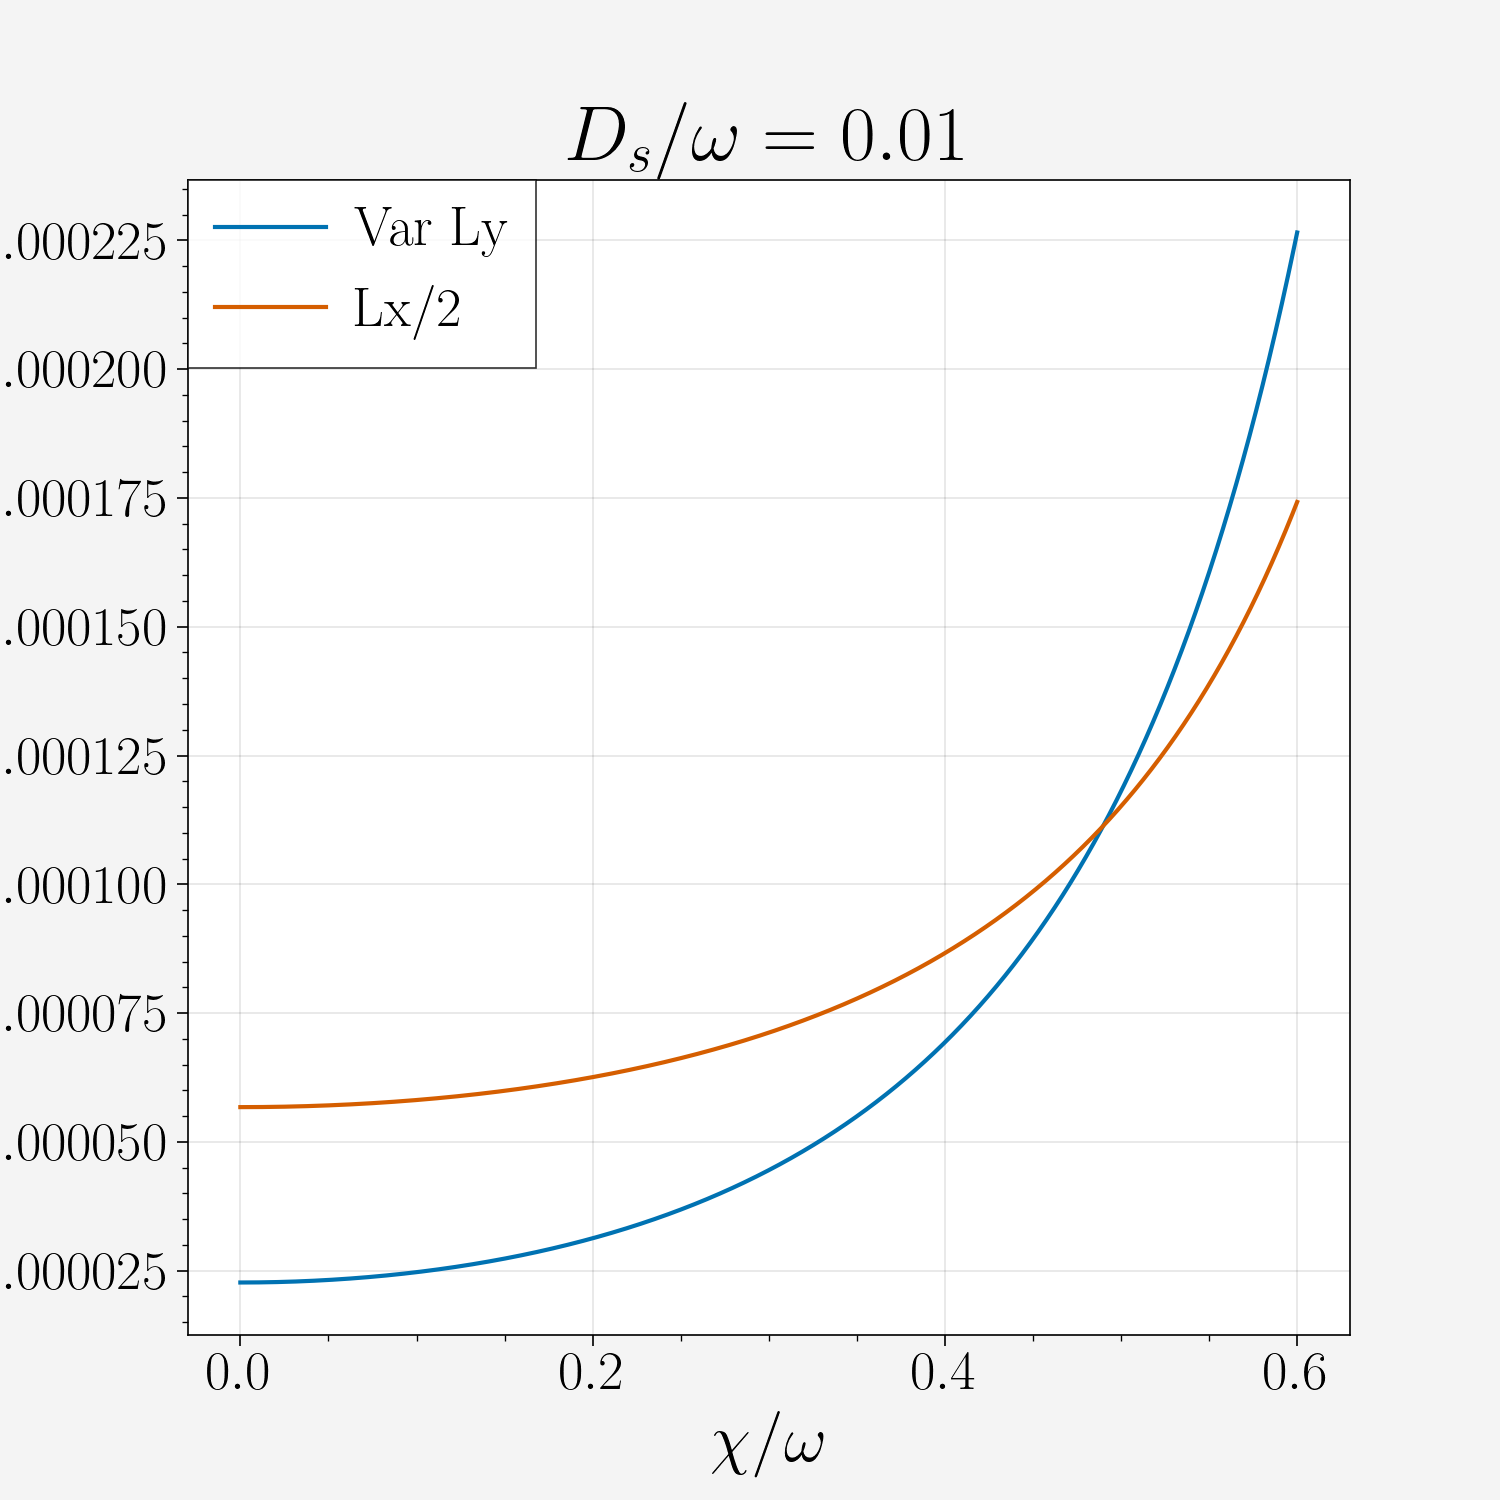

In [58]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
Ds = 0.01

y = np.arange(0,0.6,0.0001)
VarY = varLy(Ds, Dr, y)
z = Lz(Ds, Dr, y)
ax.plot(y, VarY, label = 'Var Ly')#wd_label[i])
ax.plot(y, z/2, label = 'Lx/2')#wd_label[i])
ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$D_s/\omega = 0.01$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

Notes:
- $\chi = 0$ and $D\neq 0$: Always squeezed in $J_y$
- $\chi \neq 0$ and $D\neq 0$: Squeezed below a critical $\chi$

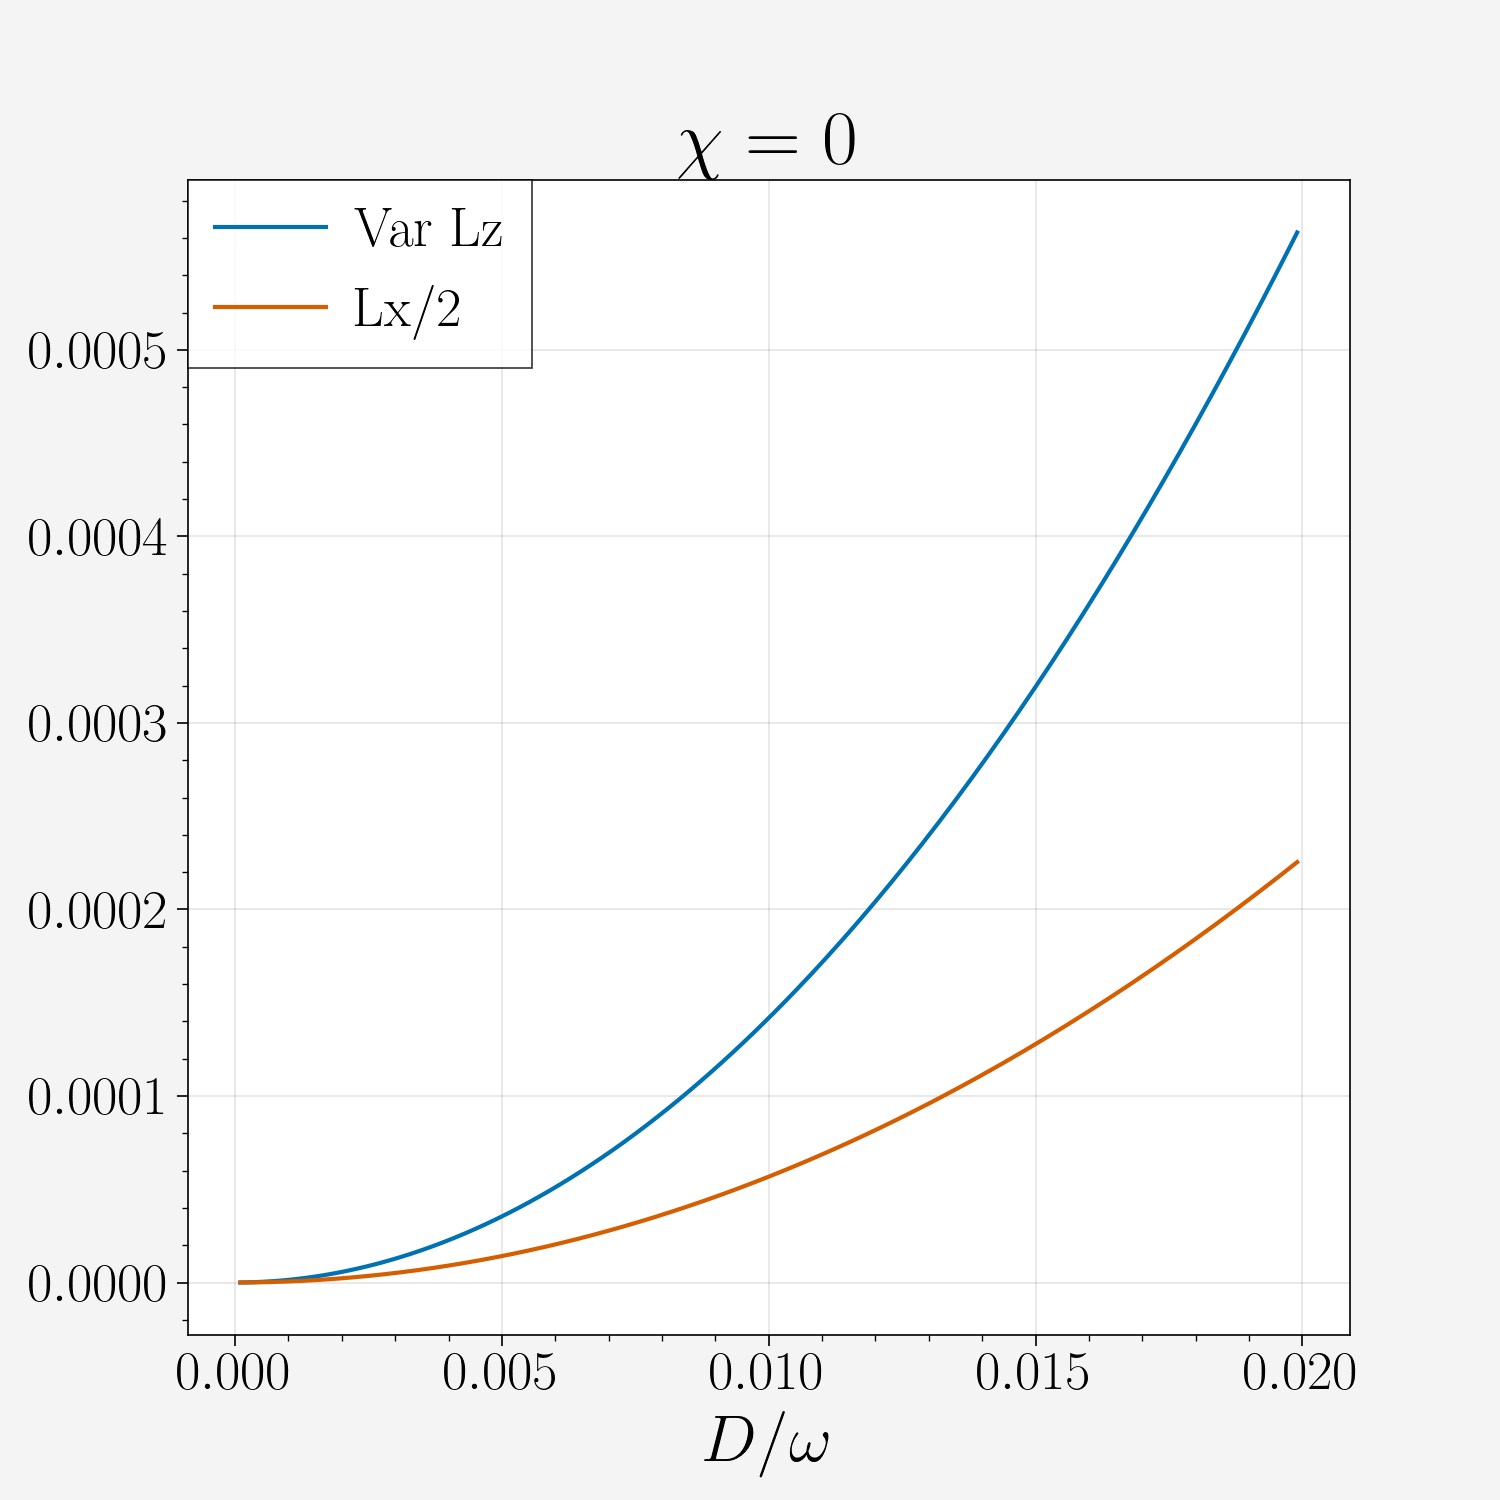

In [60]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
chi = 0

x = np.arange(0.0001,0.02,0.0001)

VarX = varLx(x, Dr, chi)
z = Lz(x, Dr, chi)
ax.plot(x, VarX, label = 'Var Lz')#wd_label[i])
ax.plot(x, z/2, label = 'Lx/2')#wd_label[i])
ax.set_xlabel(r'$D/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

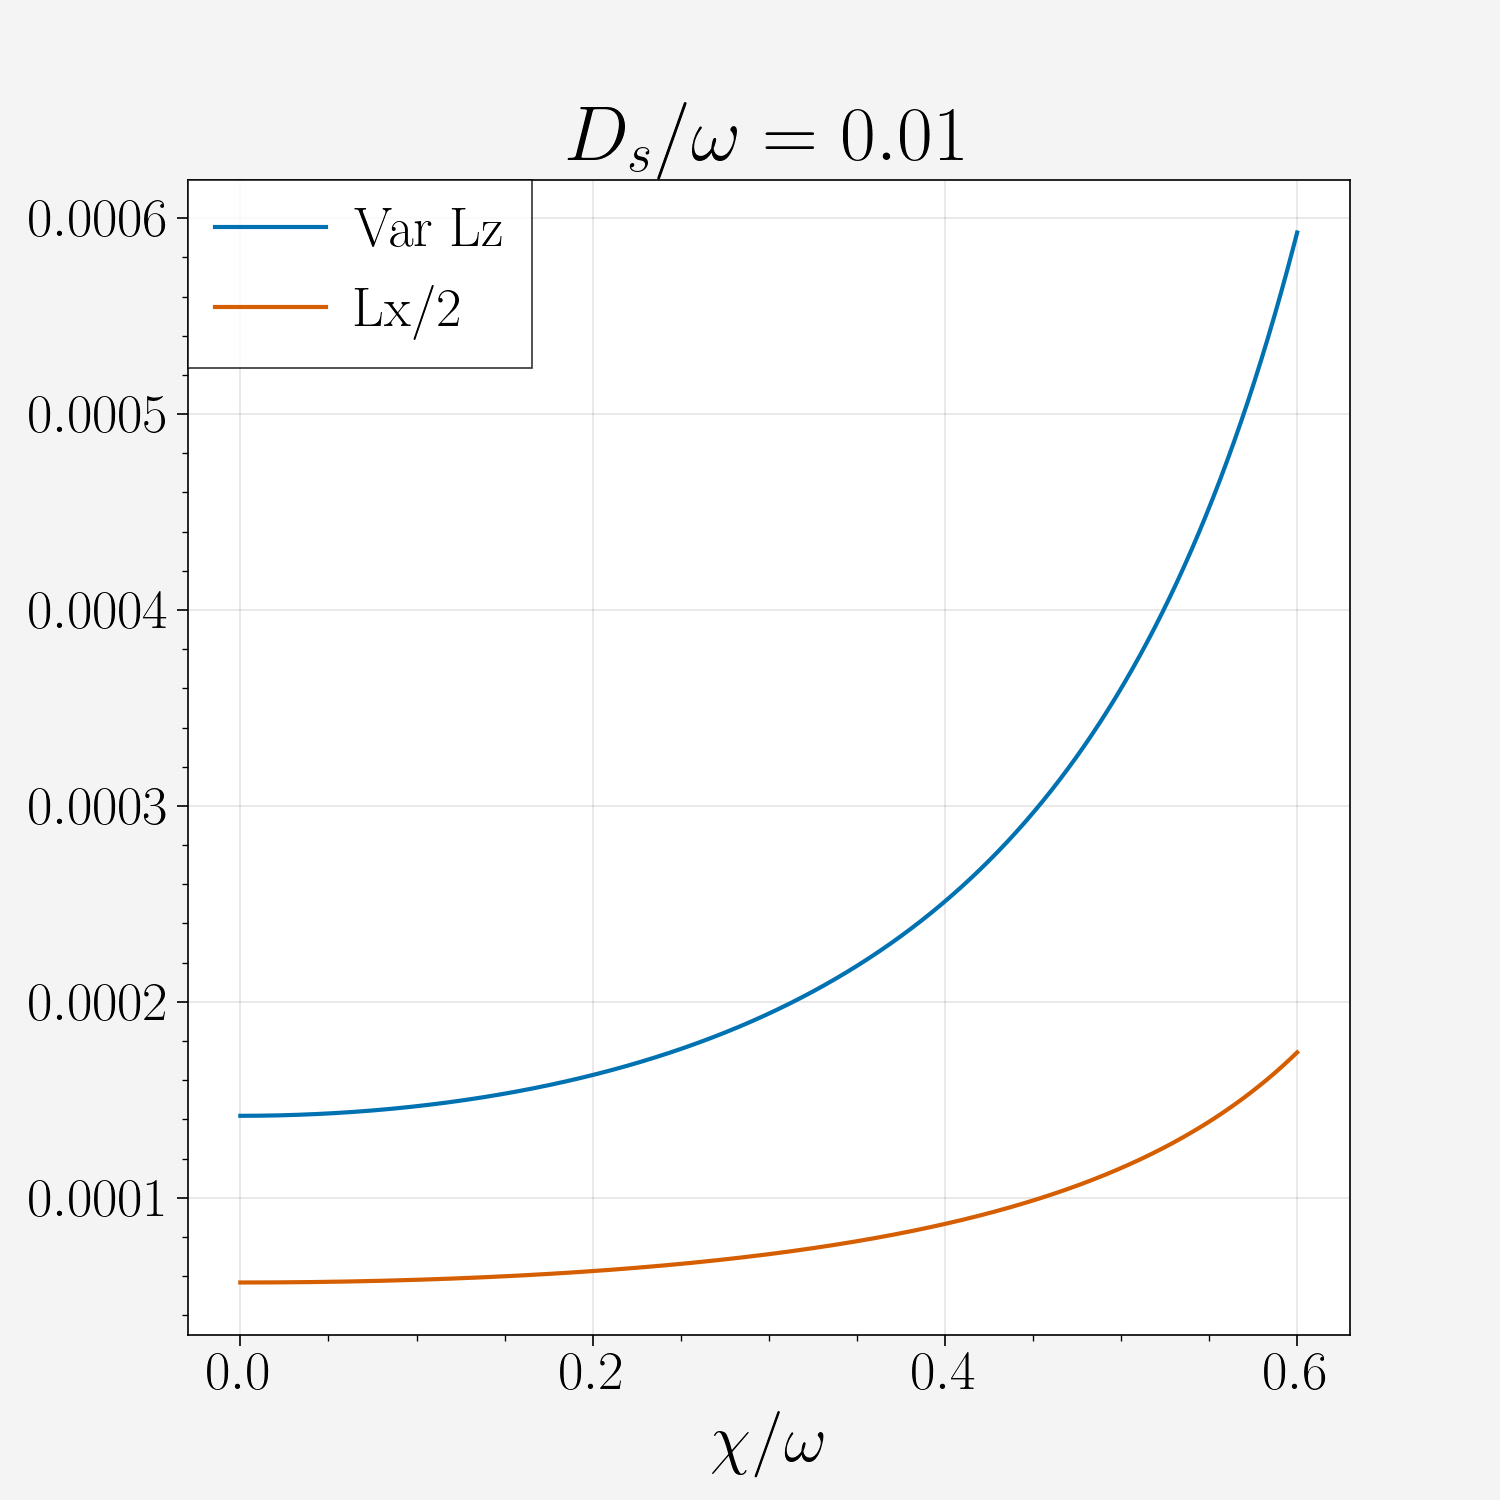

In [61]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
Ds = 0.01

y = np.arange(0,0.6, 0.0001)
VarX = varLx(Ds, Dr, y)
z = Lz(Ds, Dr, y)
ax.plot(y, VarX, label = 'Var Lz')#wd_label[i])
ax.plot(y, z/2, label = 'Lx/2')#wd_label[i])
ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$D_s/\omega = 0.01$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

Notes:
- Never squeezed in $J_x$?

Defined via \begin{equation}s_i = \frac{2\langle\Delta\hat{L}_i^2\rangle}{|\langle \hat{L}_x\rangle|} < 1\end{equation}

C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3898448954.py:6: RuntimeWarning: invalid value encountered in multiply
  varLx = np.sin(th)**2*(np.cosh(r1)**2*np.sinh(r1)**2 + np.cosh(r2)**2*np.sinh(r2)**2+np.sinh(r1)**4+np.sinh(r2)**4)/4 + np.cos(th)**2*(np.cosh(r1)*np.sinh(r1)*np.cosh(r2)*np.sinh(r2) + np.sinh(r1)**2*np.sinh(r2)**2)/2 + (np.sinh(r1)**2 + np.sinh(r2)**2)/4
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/2824406472.py:6: RuntimeWarning: invalid value encountered in subtract
  varLy = (np.cosh(r1)*np.sinh(r2)-np.cosh(r2)*np.sinh(r1))**2/4


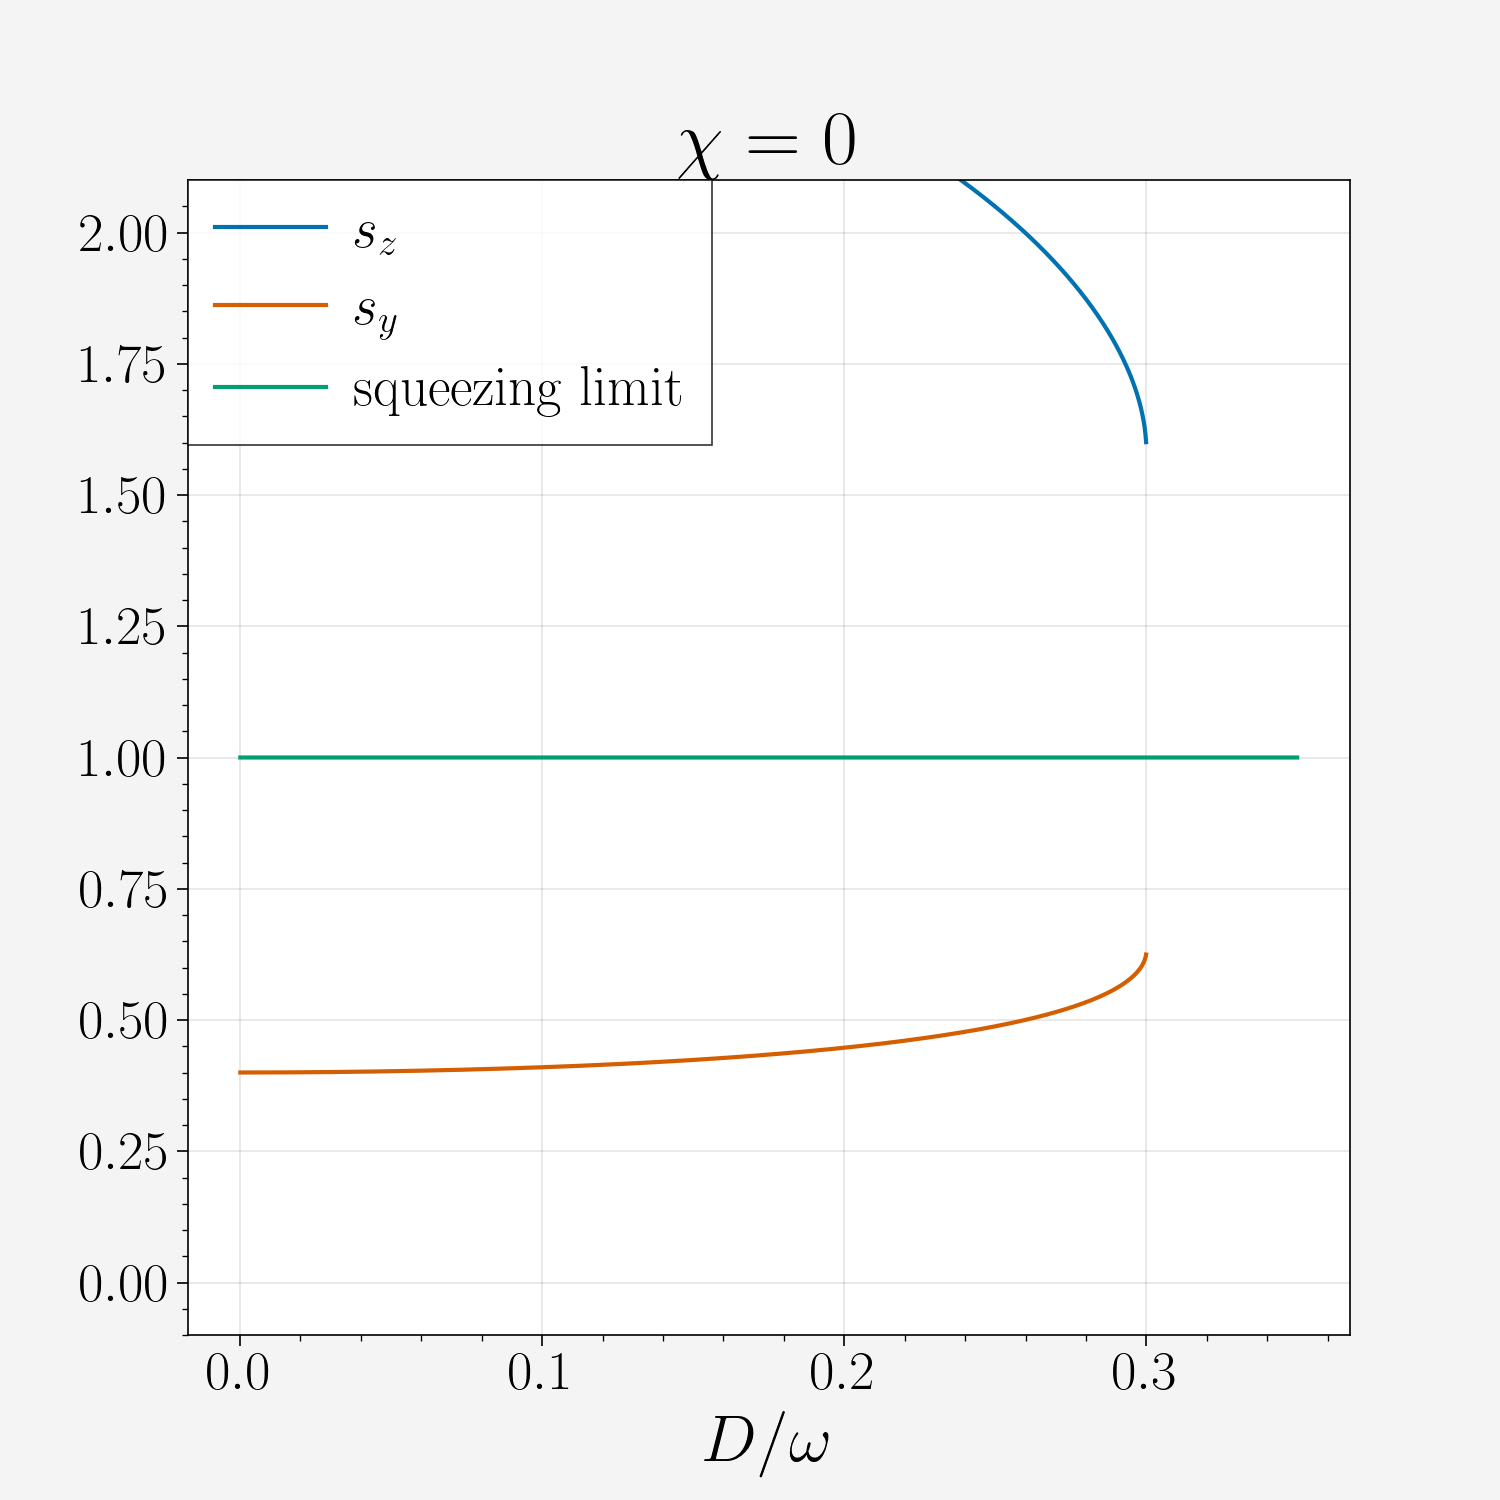

In [65]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
chi = 0

x = np.arange(0.0001,0.35,0.0001)

c = x*0 +1

sx = ellX(x, Dr, chi)
sy = ellY(x, Dr, chi)
ax.plot(x, sx, label = '$s_z$')#wd_label[i])
ax.plot(x, sy, label = '$s_y$')#wd_label[i])

ax.plot(x, c, label = 'squeezing limit')#wd_label[i])

ax.set_xlabel(r'$D/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
ax.set_ylim([-0.1, 2.1])
plt.legend(fontsize=20)
plt.show()

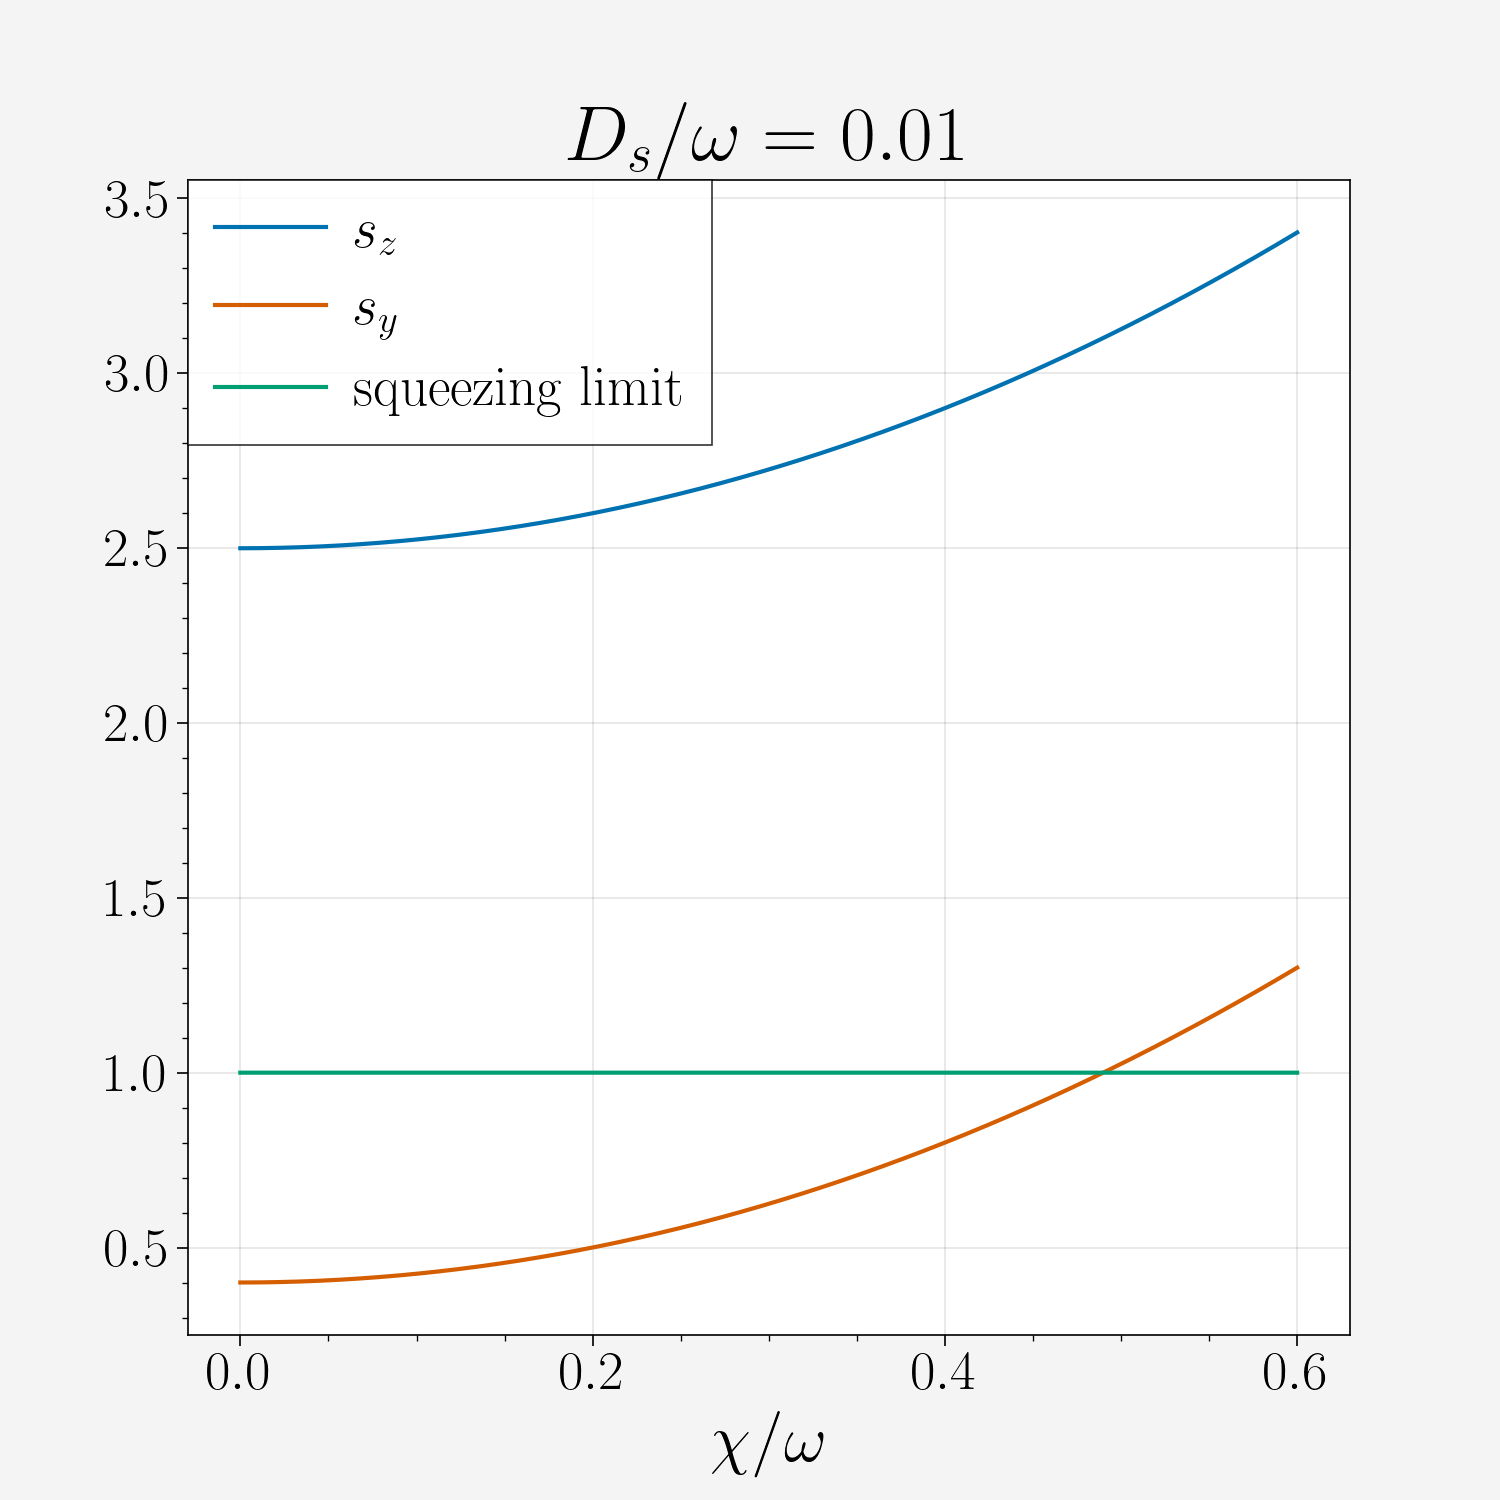

In [67]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4
Ds = 0.01
 
y = np.arange(0,0.6, 0.0001)

c = y*0 +1

sx = ellX(Ds, Dr, y)
sy = ellY(Ds, Dr, y)
ax.plot(y, sx, label = '$s_z$')#wd_label[i])
ax.plot(y, sy, label = '$s_y$')#wd_label[i])

ax.plot(y, c, label = 'squeezing limit')#wd_label[i])

ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$D_s/\omega = 0.01$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

Is minimal Heisenberg \begin{equation}\langle\Delta\hat{L}_y^2\rangle \langle\Delta\hat{L}_z^2\rangle= \frac{1}{4}|\langle \hat{L}_x\rangle|^2\end{equation} fulfilled?

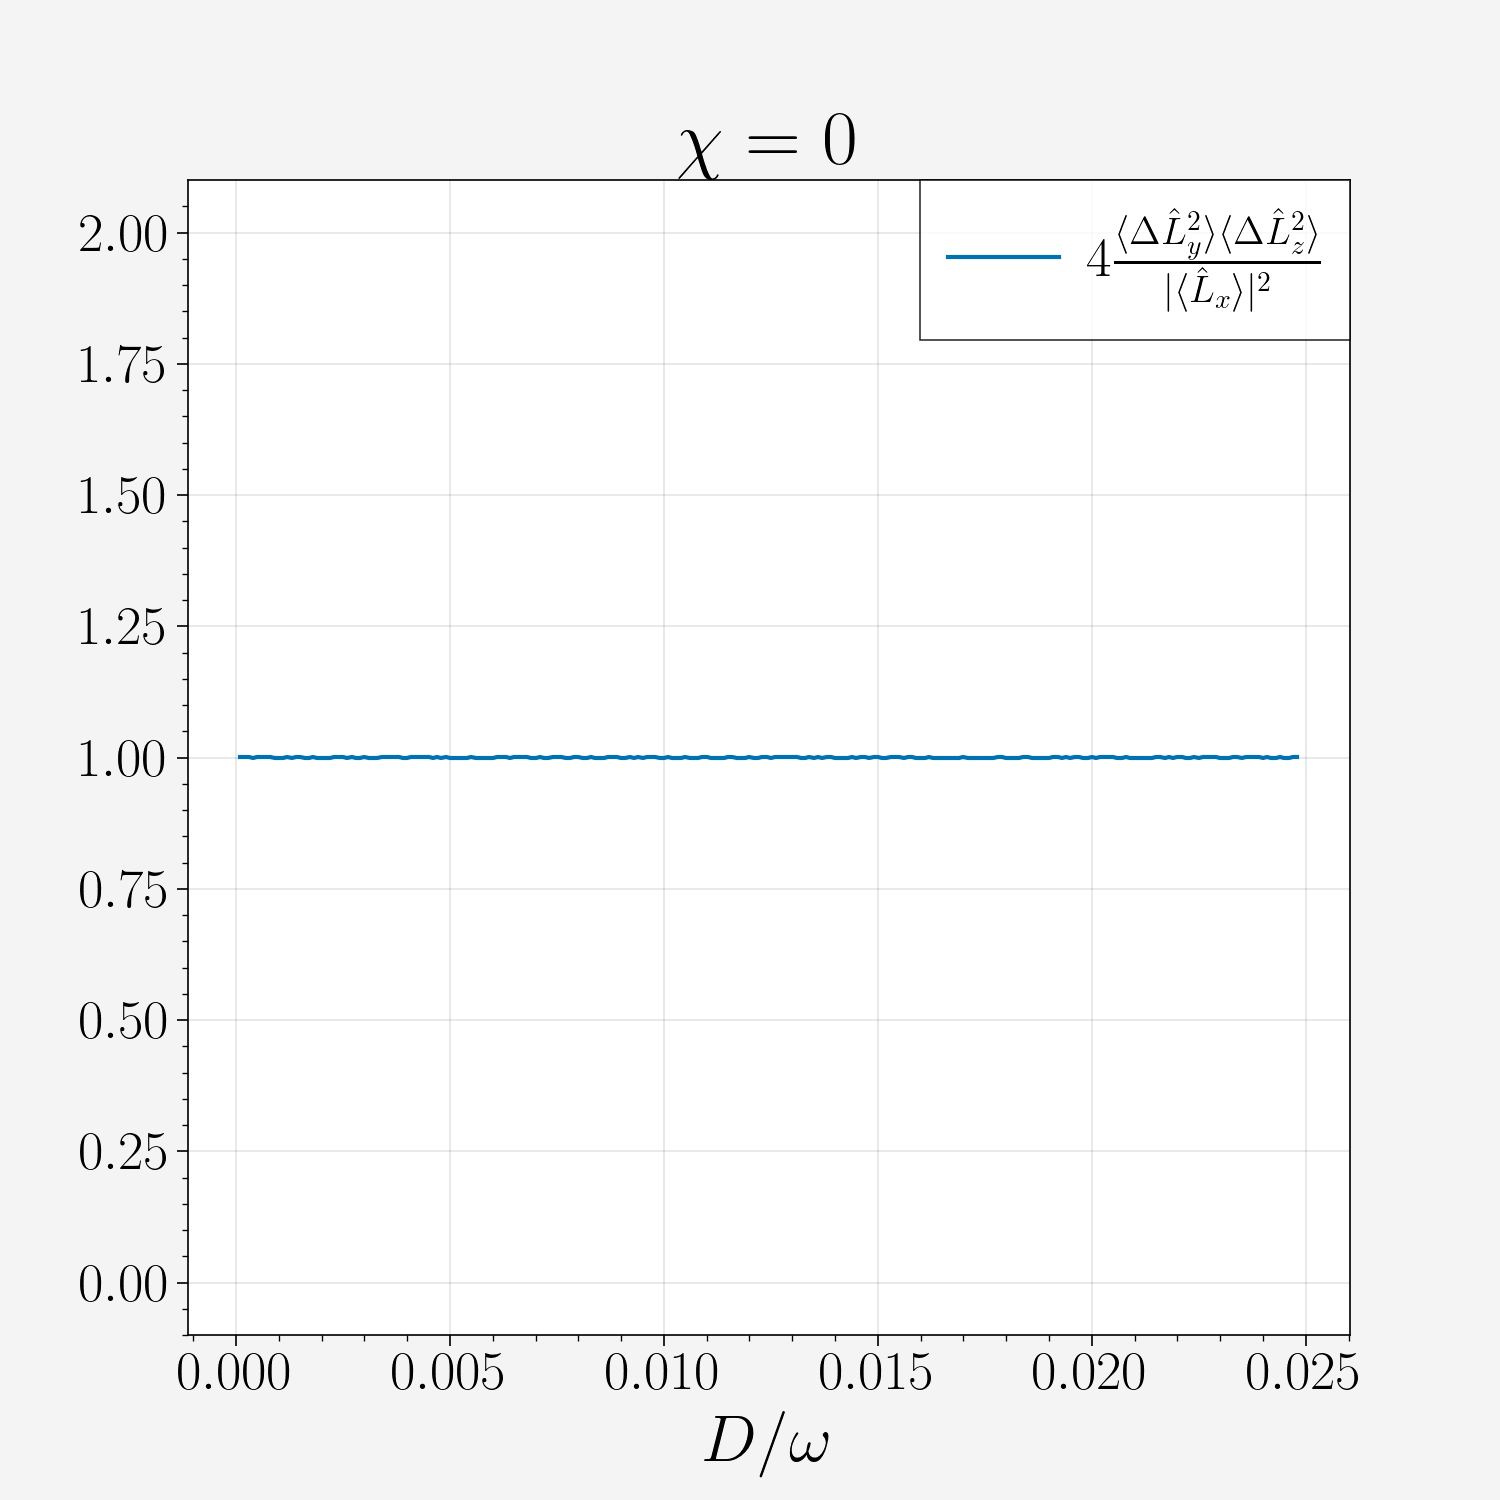

In [25]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

r = 1.5
chi = 0

x_max = np.exp(-2*r)/2
x = np.arange(0.0001,x_max,0.0001)

sx = ellX(r, x, chi)
sy = ellY(r, x, chi)
ax.plot(x, sx*sy, label = '$4\\frac{\langle\Delta\hat{L}_y^2\\rangle \langle\Delta\hat{L}_z^2\\rangle}{|\langle \hat{L}_x\\rangle|^2}$')

ax.set_xlabel(r'$D/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
ax.set_ylim([-0.1, 2.1])
plt.legend(fontsize=20)
plt.show()

True


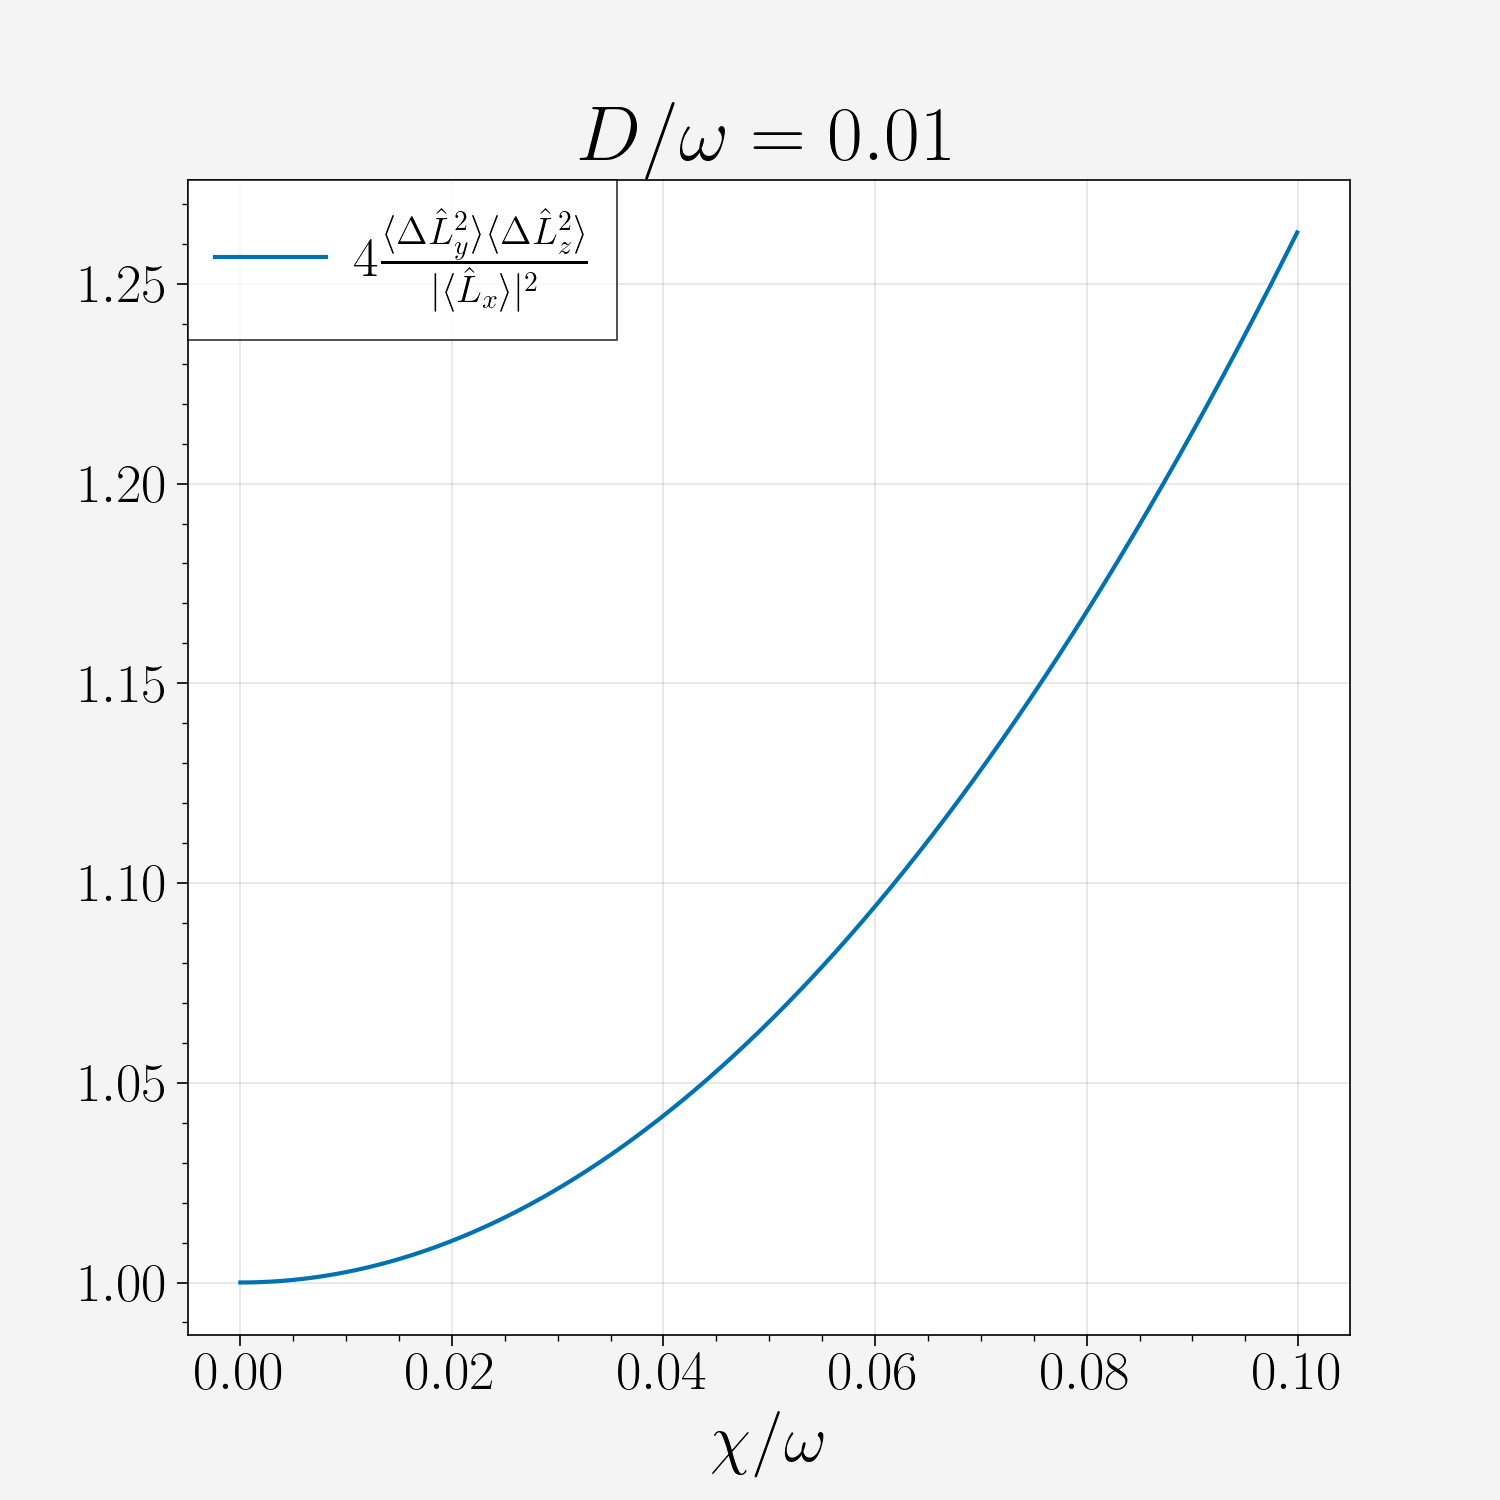

In [57]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

r = 1.5
D = 0.01

print(D < np.exp(-2*r)/2)
y_max = np.sqrt(1 - 4*D*np.cosh(2*r) + 4*D**2) 
y = np.arange(0,0.1, 0.0001)

c = y*0 +1

sx = ellX(r, D, y)
sy = ellY(r, D, y)
ax.plot(y, sx*sy, label = '$4\\frac{\langle\Delta\hat{L}_y^2\\rangle \langle\Delta\hat{L}_z^2\\rangle}{|\langle \hat{L}_x\\rangle|^2}$')

ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$D/\omega = 0.01$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

Defined by \begin{equation}\xi = -\frac{1}{4}\ln\left(\frac{\langle\Delta\hat{J}_y^2\rangle}{\langle\Delta\hat{J}_z^2\rangle}\right)\end{equation} 

C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/2824406472.py:6: RuntimeWarning: invalid value encountered in subtract
  varLy = (np.cosh(r1)*np.sinh(r2)-np.cosh(r2)*np.sinh(r1))**2/4
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_21708/2824406472.py:6: RuntimeWarning: invalid value encountered in subtract
  varLy = (np.cosh(r1)*np.sinh(r2)-np.cosh(

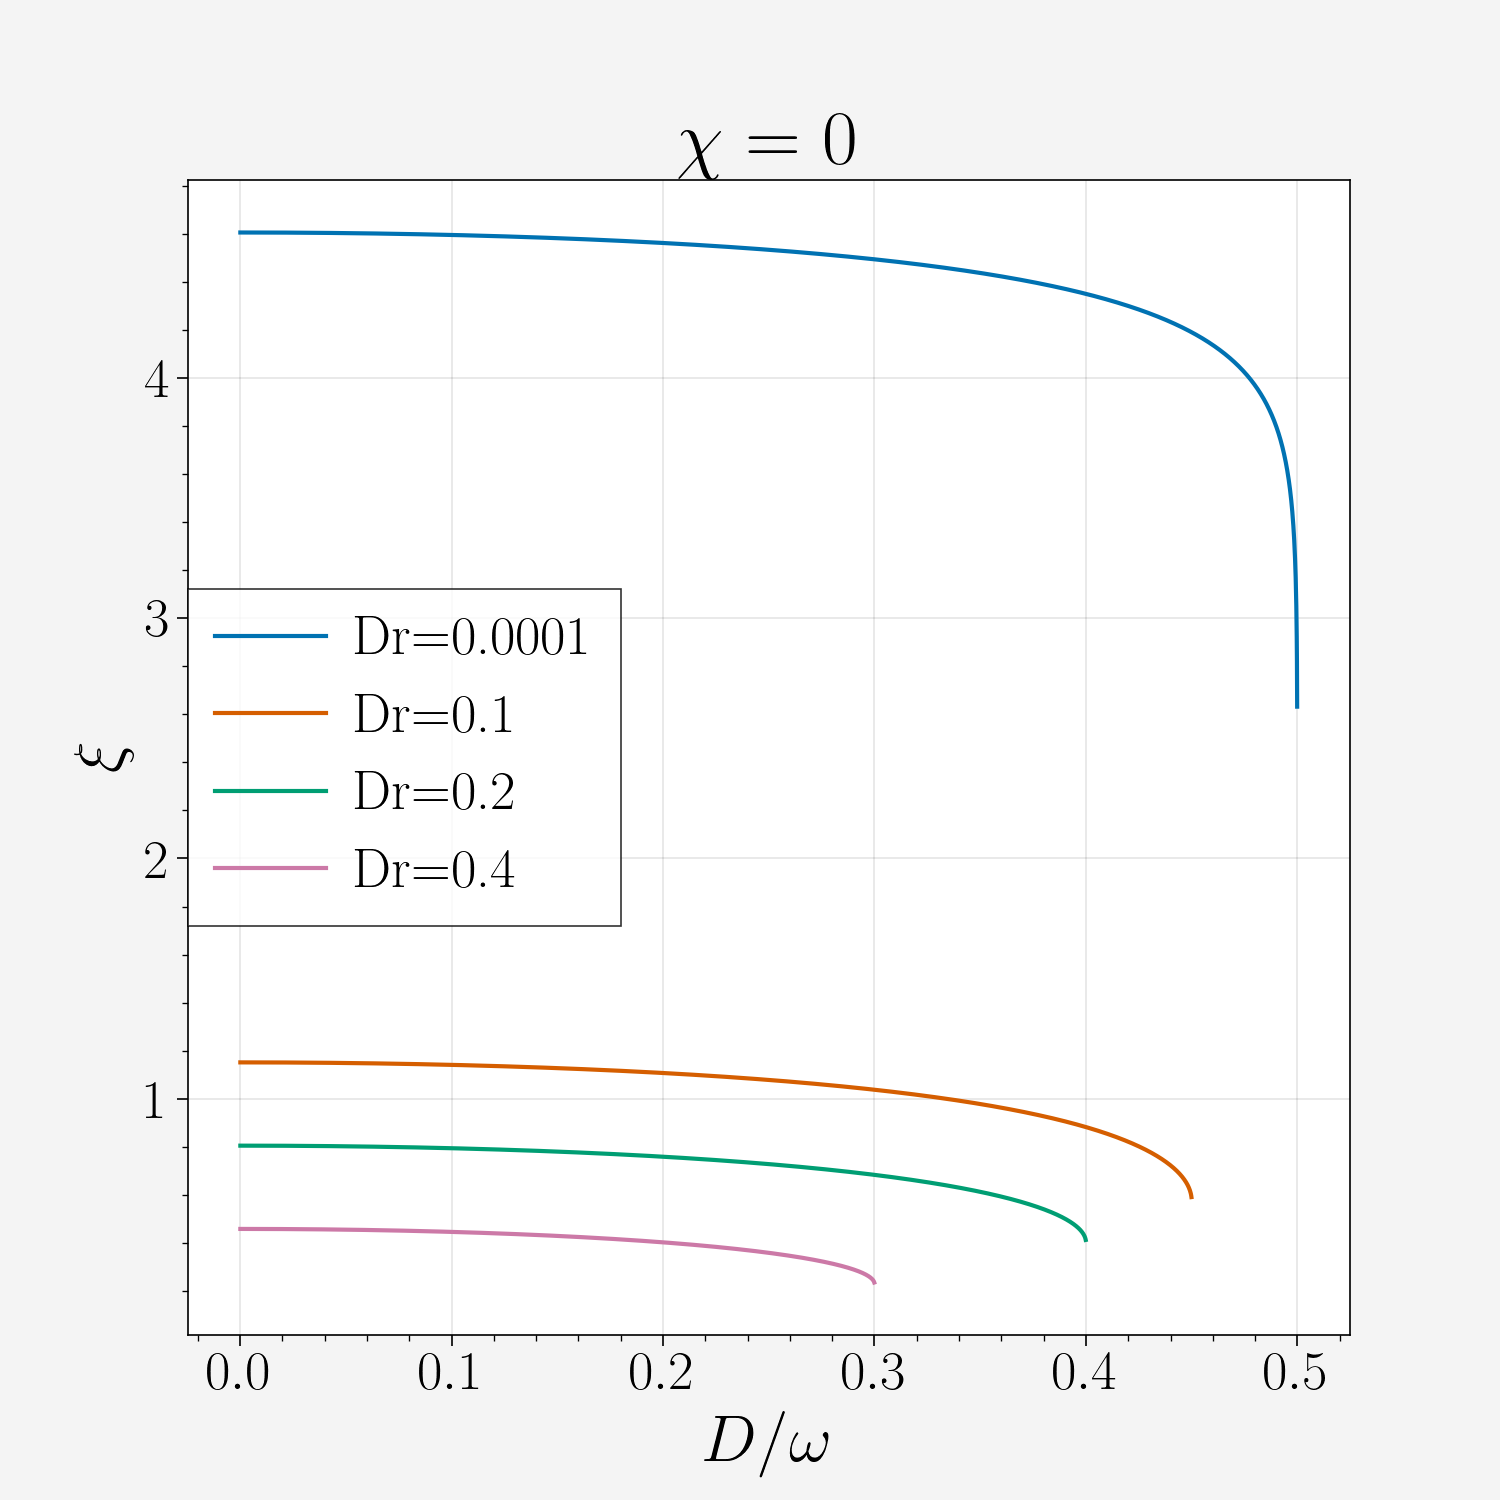

In [75]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr_arr = [0.0001,0.1, 0.2, 0.4]
chi = 0

for Dr in Dr_arr:
    x = np.arange(0.0001,0.5,0.0001)
    xi = ps_squeezing(x, Dr, chi)
    ax.plot(x, xi, label = '{}{}'.format('Dr=',Dr))

ax.set_xlabel(r'$D/\omega$', fontsize = 24)
ax.set_ylabel('$\\xi$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
#ax.set_ylim([-0.1, 2.1])
plt.legend(fontsize=20)
plt.show()

True
True
True
True


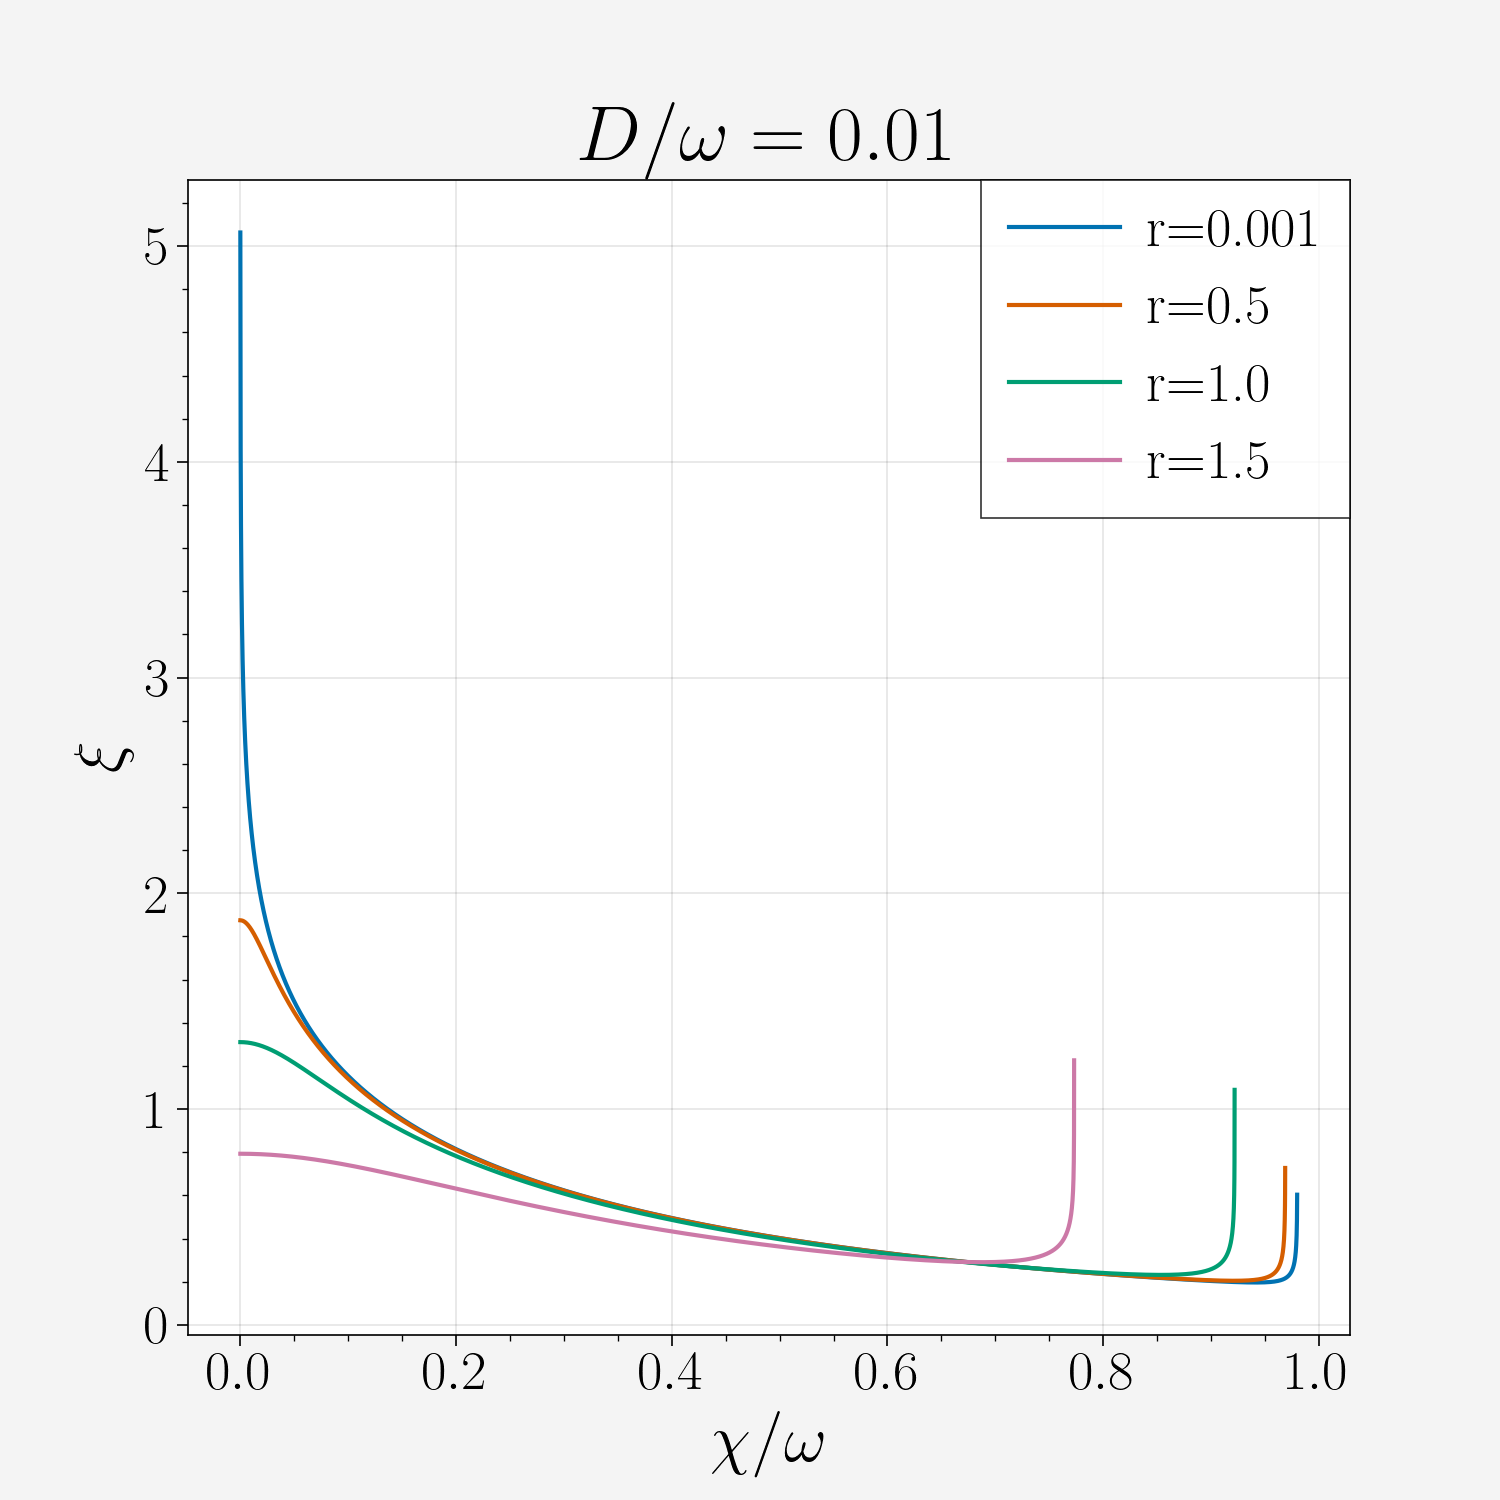

In [32]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

r_arr = [0.001, 0.5,1.0,1.5]
D = 0.01

for r in r_arr:
    print(D < np.exp(-2*r)/2)
    y_max = np.sqrt(1 - 4*D*np.cosh(2*r) + 4*D**2) 
    y = np.arange(0,y_max, 0.0001)
    xi = ps_squeezing(r, D, y)
    ax.plot(y, xi, label = '{}{}'.format('r=',r))

ax.set_ylabel('$\\xi$', fontsize = 24)
ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$D/\omega = 0.01$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

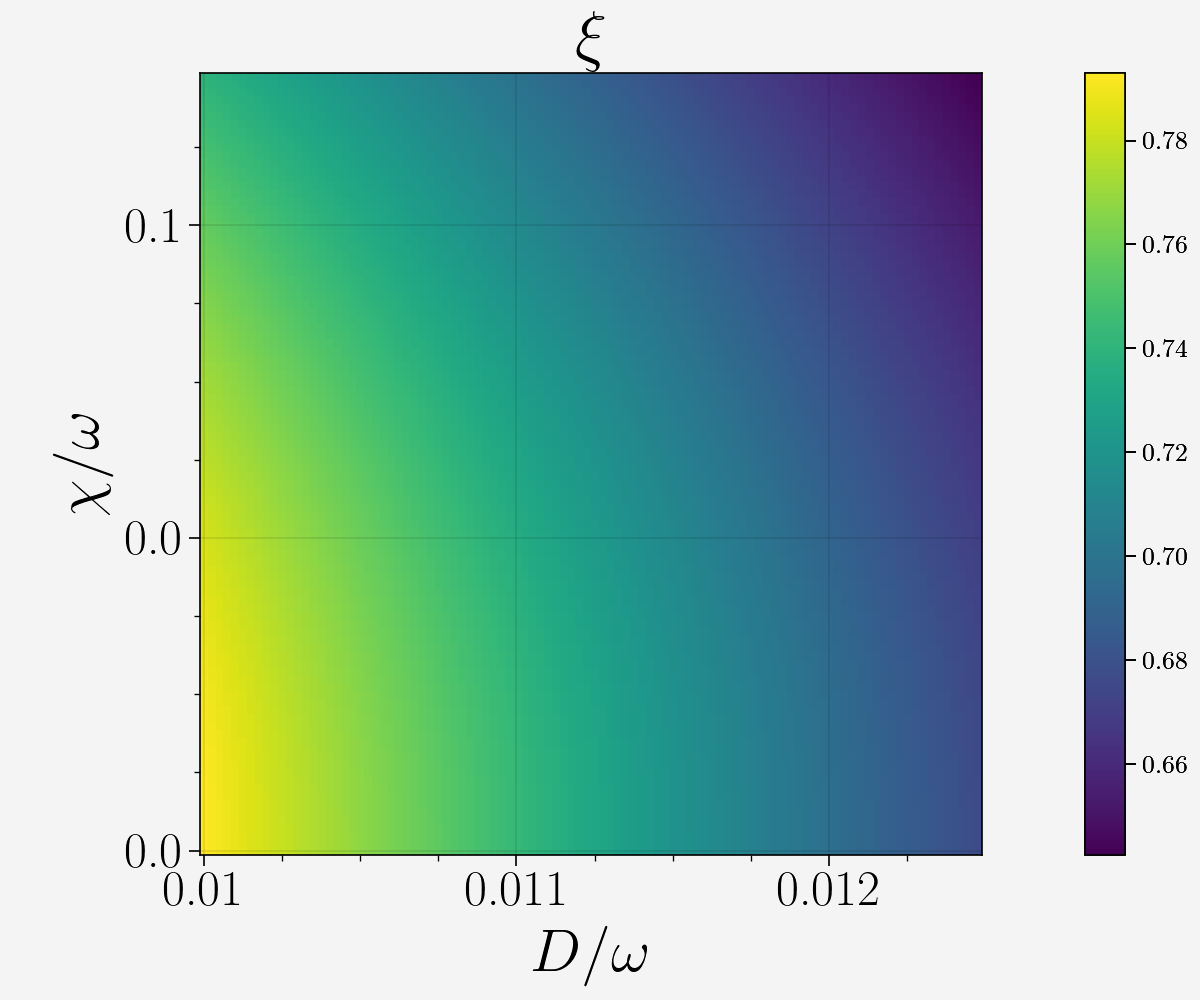

In [31]:
fig, ax = pplot.subplots(figsize=(6,5))
ax.format(
    xlabel='$D/\omega$', ylabel='$\chi/\omega$', grid=True,
    title='$\\xi$', fontsize =22
)

r = 1.5
x_max = np.exp(-2*r)/4
x = np.linspace(0.01,x_max,100)
y = np.linspace(0.0,0.1,100)
X,Y = meshgrid(x, y) # grid of point
Z = ps_squeezing(r, X, Y)

im= ax.imshow(Z, cmap=cm.viridis, origin='lower')#, extent=[x[0], 50*x[99], y[0], y[99]]) # drawing the function


ax.set_yticks([0, 40, 80])
ax.set_yticklabels([round(y[0], 3), round(y[40], 1), round(y[80],1)])
ax.set_xticks([0, 40, 80])
ax.set_xticklabels([round(x[0], 3), round(x[40], 3), round(x[80],3)])
ax.tick_params(labelsize = 18) 
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
cbar = colorbar(im) # adding the colobar on the right
#plt.clim(0,1)
# latex fashion title
show()

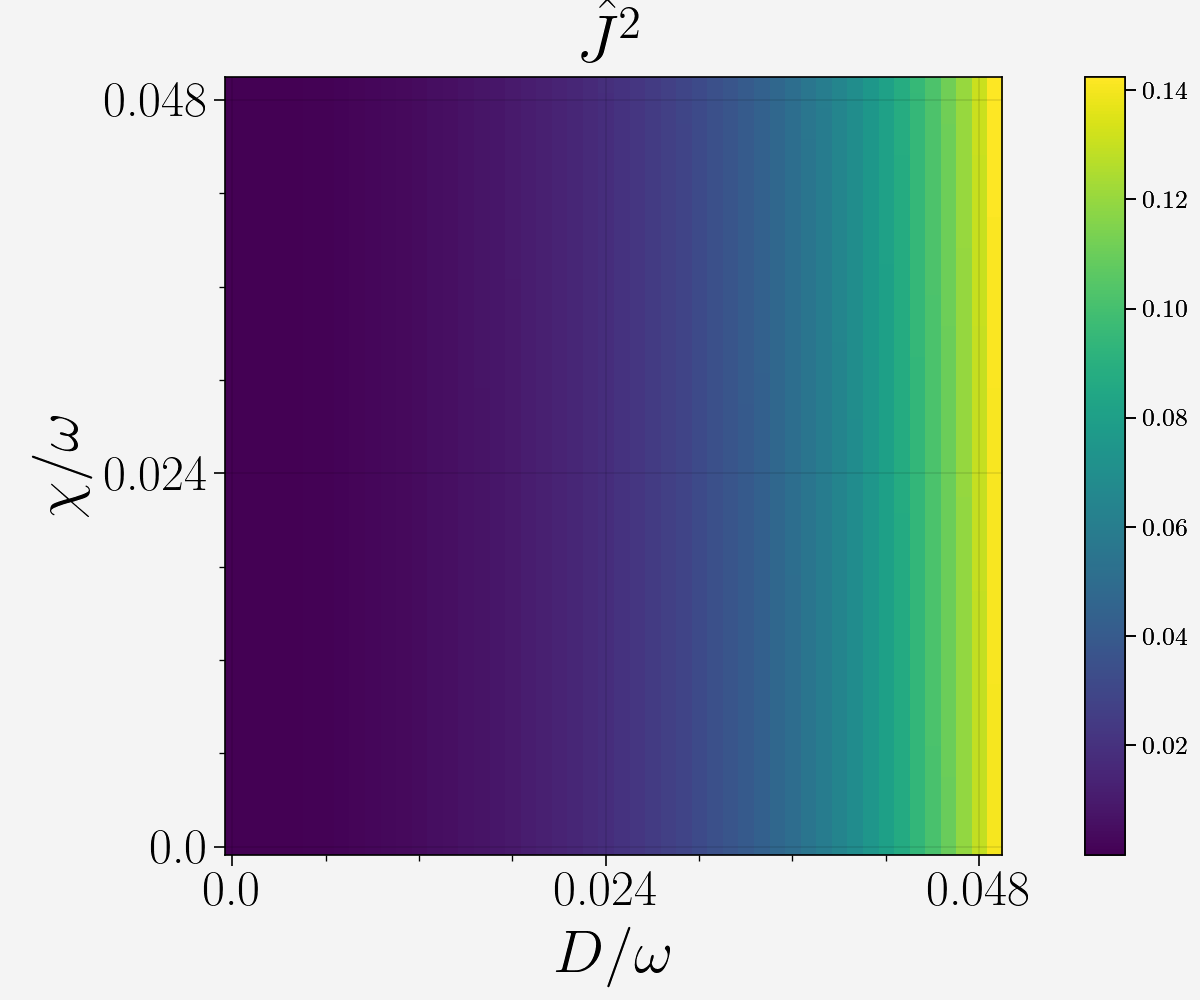

In [37]:
fig, ax = pplot.subplots(figsize=(6,5))

ax.format(
    xlabel='$D/\omega$', ylabel='$\chi/\omega$', grid=True,
    title='$\hat{J}^2$', fontsize =22
)

x = np.arange(0.0001,0.05,0.001)
y = np.arange(0.0001,0.05,0.001)
r = 1
X,Y = meshgrid(x, y) # grid of point
Z = varLx(r, X,Y) + varLy(r, X,Y) + varLz(r, X,Y) + Lx(r, X,Y)**2 + Lz(r, X,Y)**2 

lx = int(len(x)/2) -1
ly = int(len(y)/2) -1

dec = 3

ax.set_xticks([0, lx, 2*lx])
ax.set_xticklabels([round(x[0], dec), round(x[lx], dec), round(x[2*lx],dec)])
ax.set_yticks([0, ly, 2*ly])
ax.set_yticklabels([round(y[0], dec), round(y[ly], dec), round(y[2*ly],dec)])

ax.tick_params(labelsize = 18) 

im = imshow(Z,cmap=cm.viridis, origin = 'lower') # drawing the function

cbar = colorbar(im) # adding the colobar on the right
show()

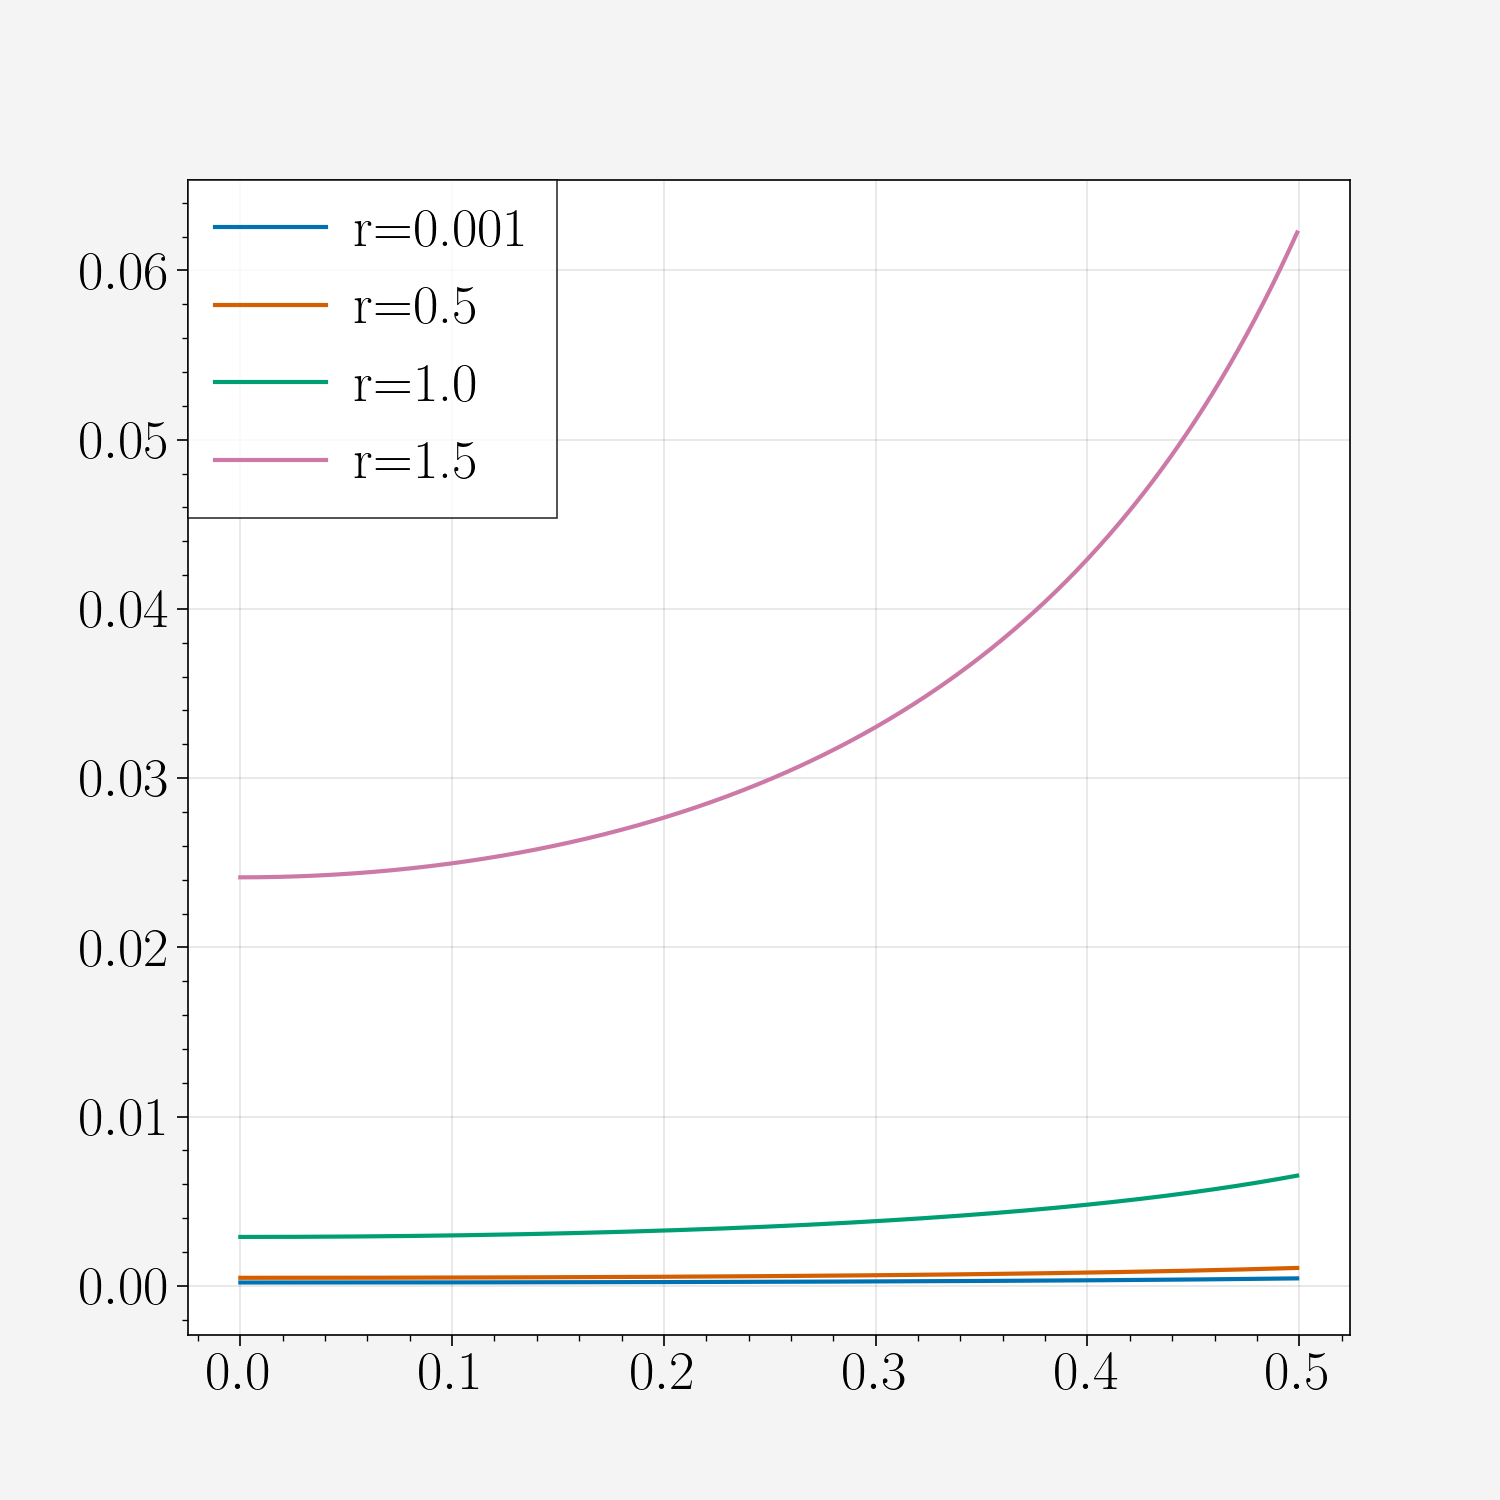

In [38]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

r_arr = [0.001, 0.5,1.0,1.5] 
x = 0.01

for r in r_arr:
    y_max = np.sqrt((1-2*x*np.cosh(2*r))**2 - (2*x*np.sinh(2*r))**2)
    y = np.arange(0,0.5,0.001)
    n = varLx(r, x,y) + varLy(r, x,y) + varLz(r, x,y) + Lx(r, x,y)**2 + Lz(r, x,y)**2
    ax.plot(y, n, label = '{}{}'.format('r=',r))#wd_label[i])
#ax.set_xlabel(r'$\chi/D$', fontsize = 24)
#ax.set_ylabel(r'$\theta$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
#ax.set_title('Contrast', fontsize = 2)
plt.legend(fontsize=20)
plt.show()

In [118]:
rs = 1
ra = 0.4
m=1
Lxm0 = (m+1/2)/2*np.cosh(2*rs) - np.cosh(2*ra)/4
VLym0 = (m+1/2)/4*np.cosh(2*rs - 2*ra) - 1/8
VLzm0 = (m+1/2)/4*np.cosh(2*rs + 2*ra) - 1/8

In [119]:
print(4*VLym0*VLzm0/Lxm0**2)

1.06374519220006


In [138]:
rs = 1.2
ra = 1
m=1.0
n=0.0
Lxm0 = 1/2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 - (n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2))
VLym0 = 1/4*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 + (n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2) 
             + 2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2)*(n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2) 
             - 2*(2*m+1)*(2*n+1)*np.cosh(rs)*np.sinh(rs)*np.cosh(ra)*np.sinh(ra))
VLzm0 = 1/4*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 + (n*(np.cosh(ra)**2 + np.sinh(ra)**2)
            + np.sinh(ra)**2) + 2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2)*(n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2) 
             + 2*(2*m+1)*(2*n+1)*np.cosh(rs)*np.sinh(rs)*np.cosh(ra)*np.sinh(ra))

In [139]:
print(4*VLym0*VLzm0/Lxm0**2)

1.6315246382800386


In [143]:
print(Lxm0, Lxm0/2, VLym0, VLzm0)

3.2271614524532217 1.6135807262266109 0.2804021394394196 15.149339875913341


In [90]:
print(2*(2*m+1)*(2*n+1)*np.cosh(rs)*np.sinh(rs)*np.cosh(ra)*np.sinh(ra))

1.6105182123841895


In [111]:
print(1/4*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 + (n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2) 
             + 2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2)*(n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2) 
             - 2*(2*m+1)*(2*n+1)*np.cosh(rs)*np.sinh(rs)*np.cosh(ra)*np.sinh(ra)))

0.1013319459155469


In [102]:
print(1/2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 - (n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2)))

0.6061901861946966


In [109]:
print(1/2*(m*(np.cosh(rs)**2 + np.sinh(rs)**2) + np.sinh(rs)**2 - (n*(np.cosh(ra)**2 + np.sinh(ra)**2) + np.sinh(ra)**2)))

0.6061901861946966


8.252728416861132

In [120]:
print(2*VLym0/Lxm0)

0.44546174844082337


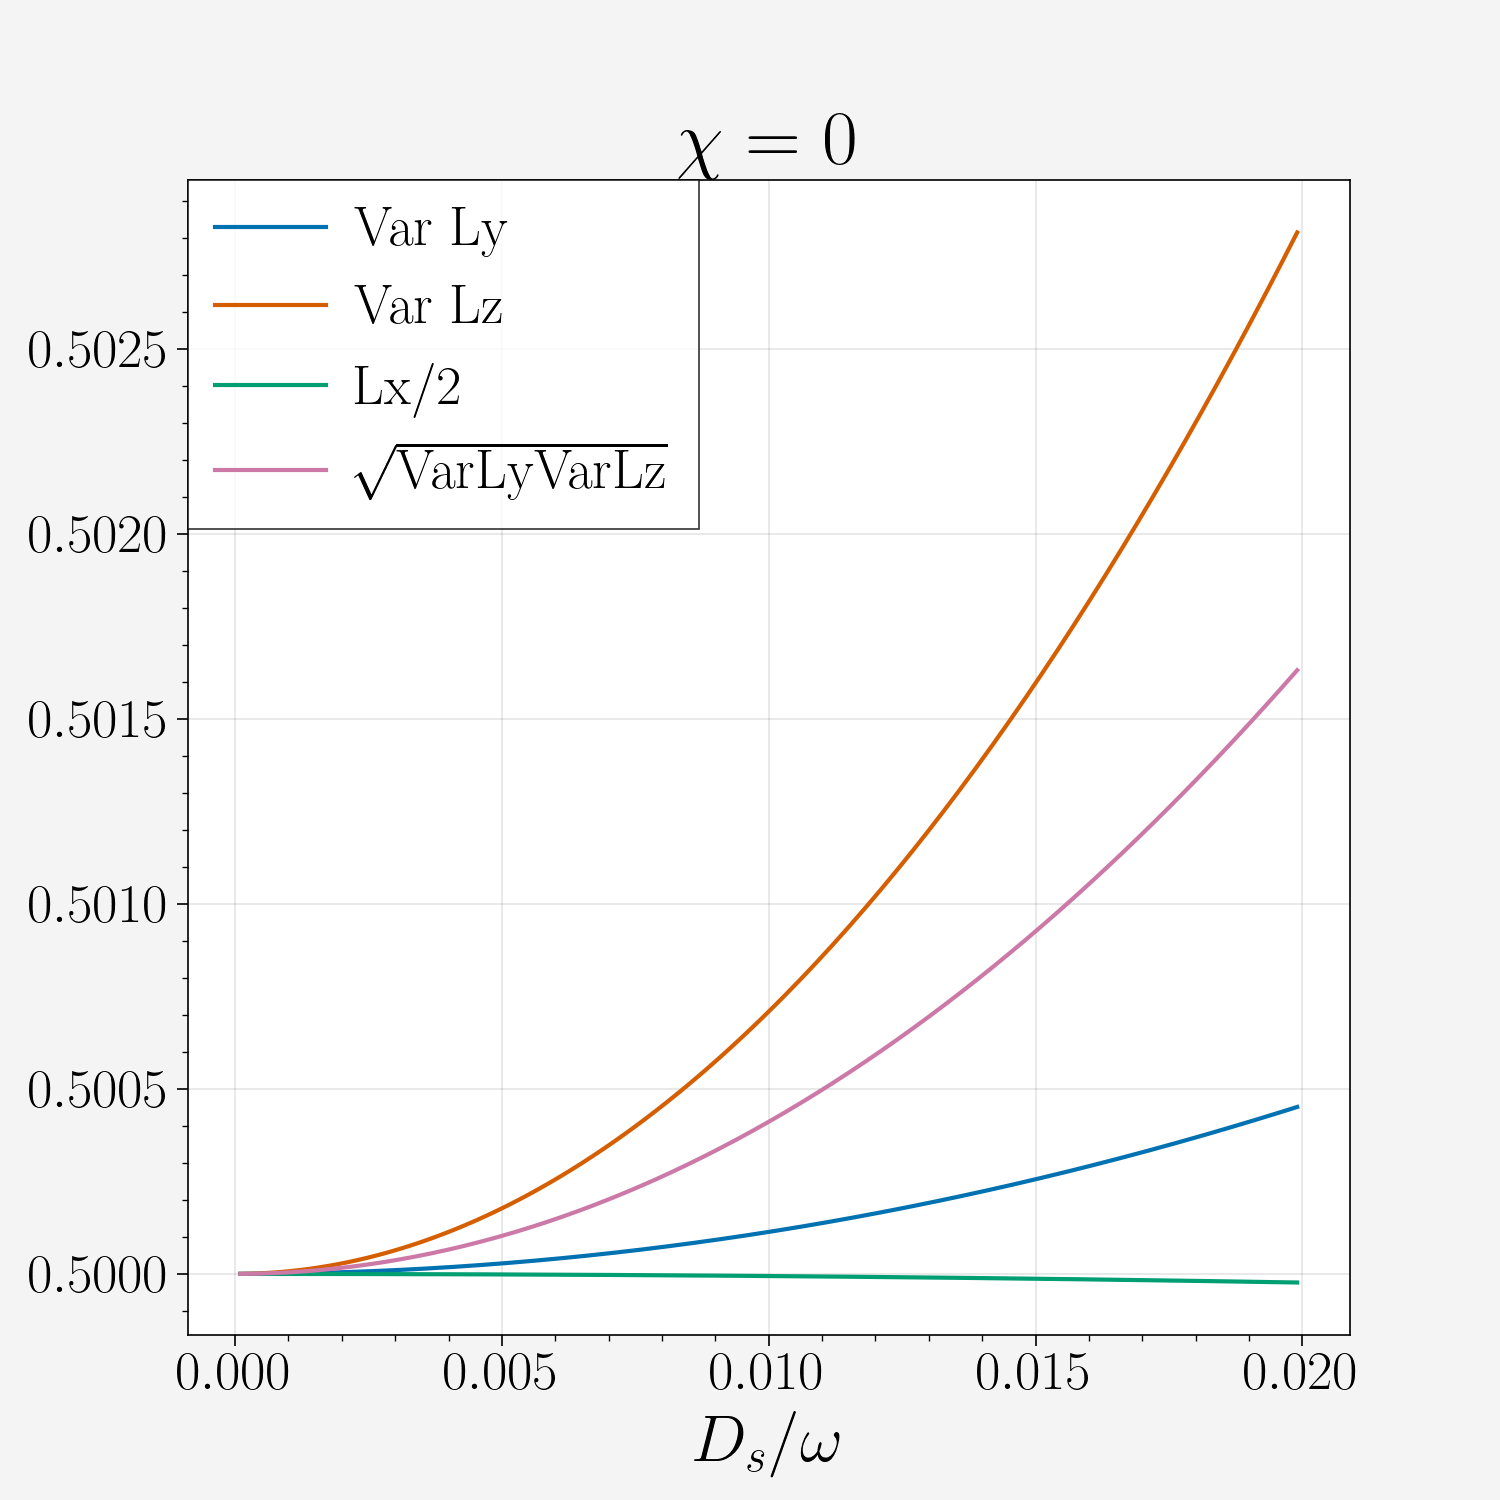

In [34]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4

x = np.arange(0.0001,0.02,0.0001)
m,n = 0,2
VarY = varLy_mn(x, Dr, m,n)
X = np.abs(Lx_mn(x, Dr, m,n))
VarZ = varLz_mn(x, Dr, m,n)

ax.plot(x, VarY, label = 'Var Ly')#wd_label[i])
ax.plot(x, VarZ, label = 'Var Lz')#wd_label[i])
ax.plot(x, X/2, label = r'Lx/2')#wd_label[i])
ax.plot(x, np.sqrt(VarY*VarZ), label = r'$\sqrt{\mathrm{VarLyVarLz}}$')#wd_label[i])
ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

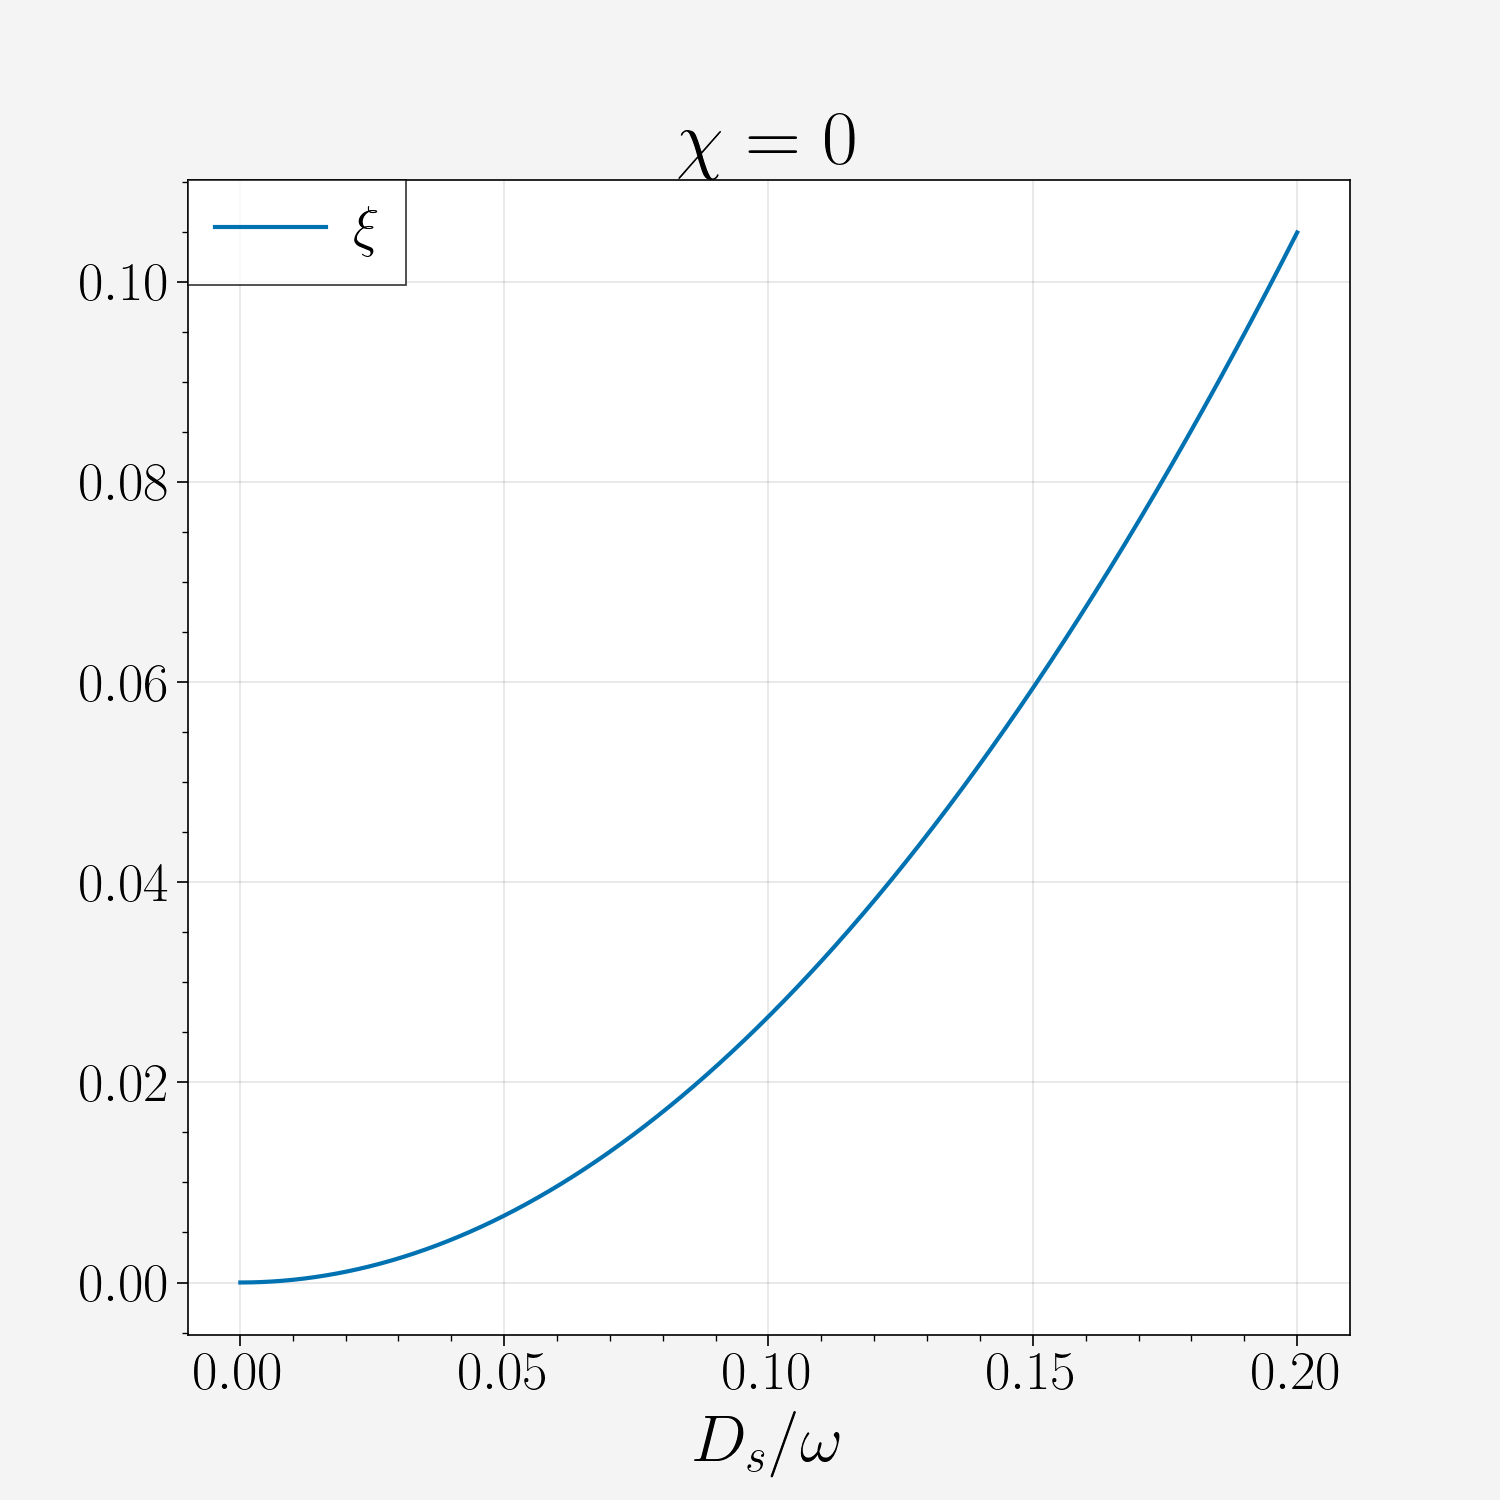

In [28]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

Dr = 0.4

x = np.arange(0.0001,0.2,0.0001)
m,n = 1,1
VarY = varLy_mn(x, Dr, m,n)
X = np.abs(Lx_mn(x, Dr, m,n))
VarZ = varLz_mn(x, Dr, m,n)

ax.plot(x, -1/4*np.log(VarY/VarZ), label = r'$\xi$')#wd_label[i])

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.show()

# Paper figures

## Fig2

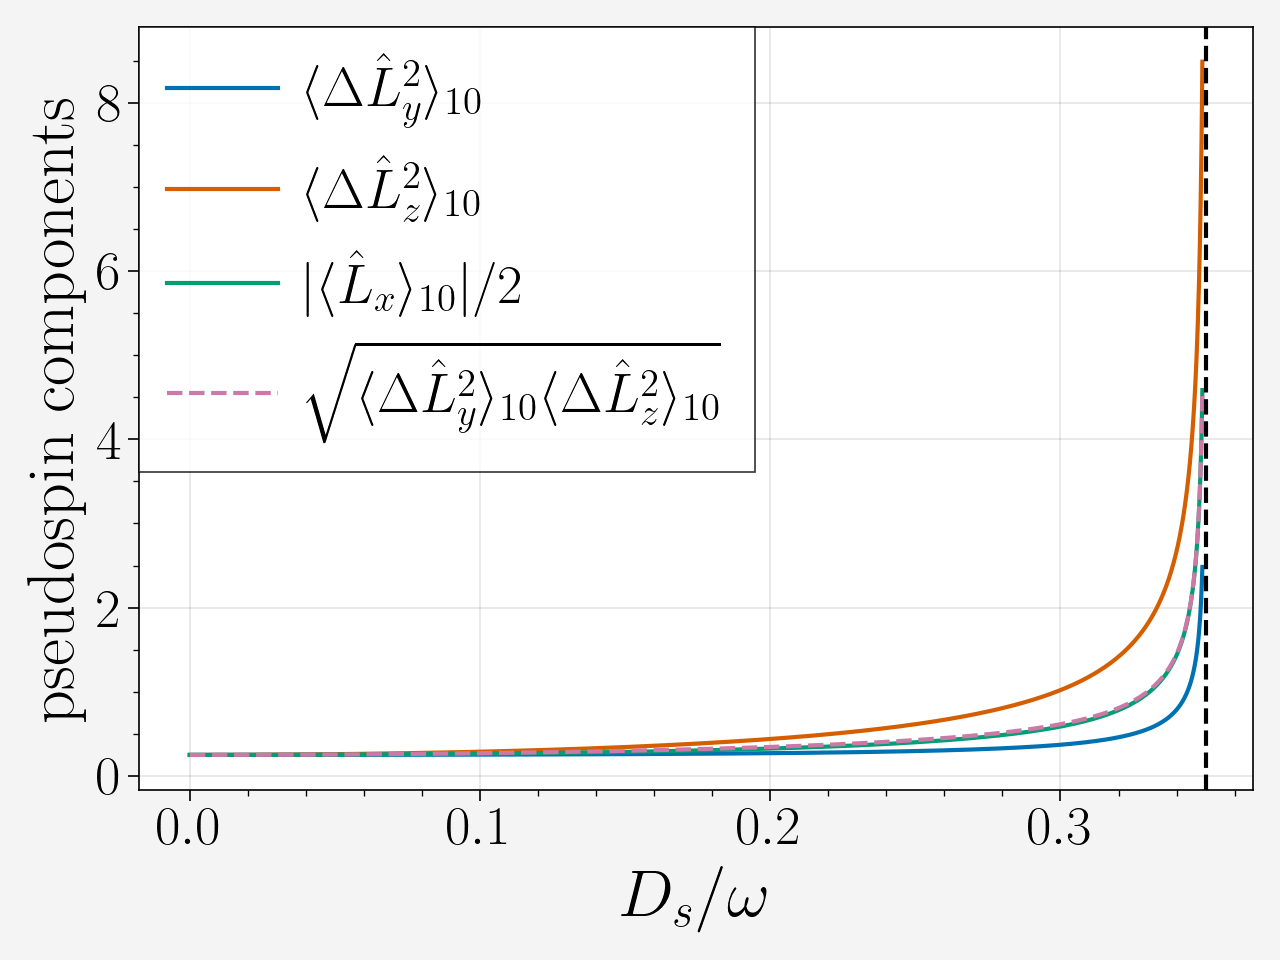

In [30]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

Dr = 0.3

x = np.arange(0,0.349,0.0001)
m,n = 1,0
VarY = varLy_mn(x, Dr, m,n)
X = np.abs(Lx_mn(x, Dr, m,n))
VarZ = varLz_mn(x, Dr, m,n)

ax.plot(x, VarY, label = r'$\langle \Delta \hat{L}_y^2\rangle_{10}$')#wd_label[i])
ax.plot(x, VarZ, label = r'$\langle \Delta \hat{L}_z^2 \rangle_{10}$')#wd_label[i])
ax.plot(x, X/2, label = r'$|\langle \hat{L}_x\rangle_{10}|$/2')#wd_label[i])
ax.plot(x, np.sqrt(VarY*VarZ), label = r'$\sqrt{\langle \Delta \hat{L}_y^2\rangle_{10}\langle \Delta \hat{L}_z^2\rangle_{10}}$', linestyle = '--')#wd_label[i])
#ax.plot(x,2*VarY/X)

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin components', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.axvline(0.35, linestyle = '--', color = 'black')
plt.legend(fontsize=20)
plt.savefig('fig2a.svg')
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/74294631.py:5: RuntimeWarning: invalid value encountered in subtract
  varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2


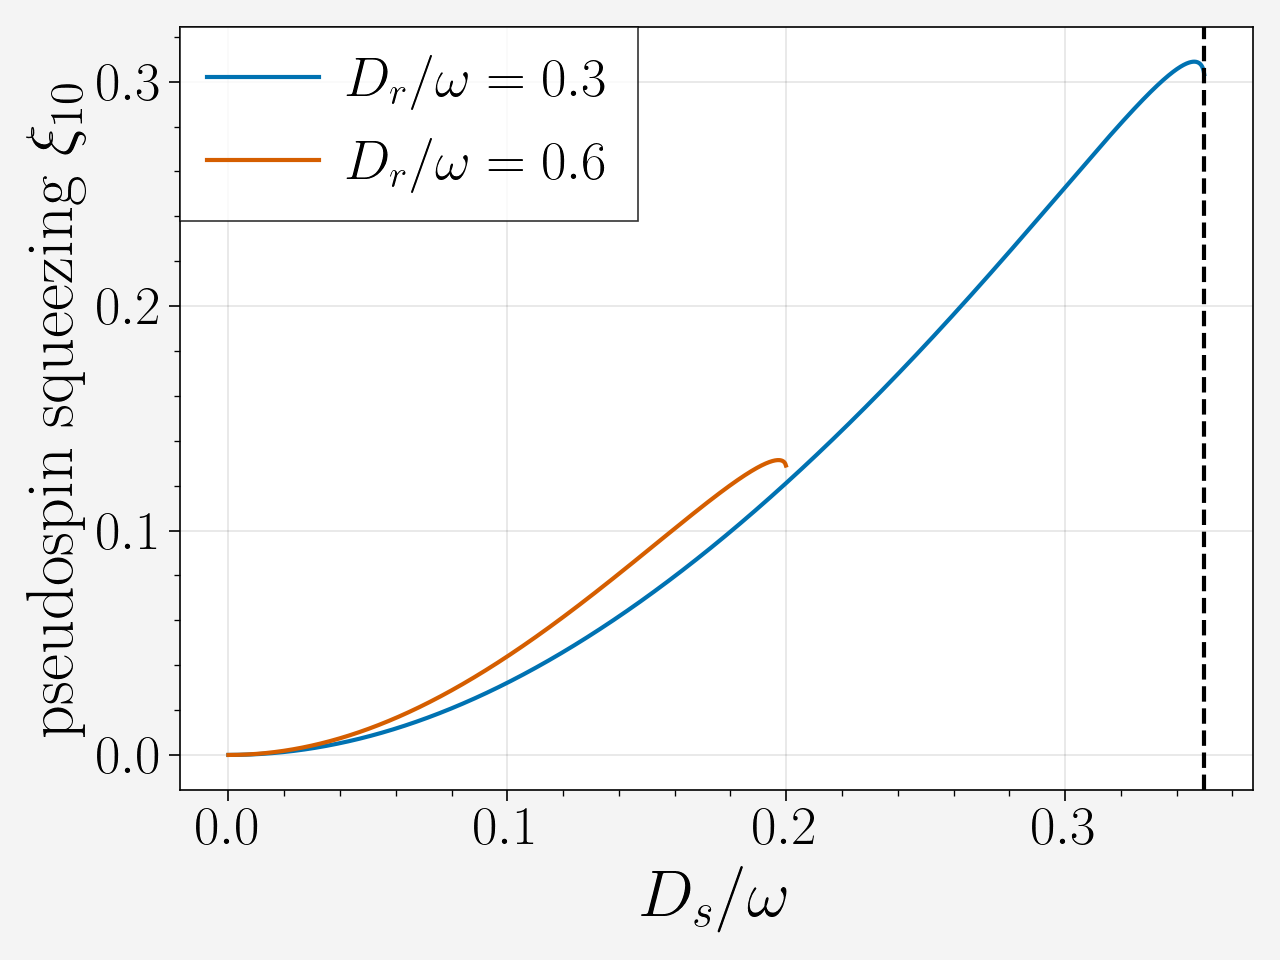

In [41]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

x = np.arange(0.0,0.5,0.0001)
m,n = 1,0
Dr = 0.0
#ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.0$')

Dr = 0.3
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$')

Dr = 0.6
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.6$')

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin squeezing $\xi_{10}$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.05,0.1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.axvline(0.35, linestyle = '--', color = 'black')
plt.savefig('fig2b.svg')
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/74294631.py:5: RuntimeWarning: invalid value encountered in subtract
  varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2


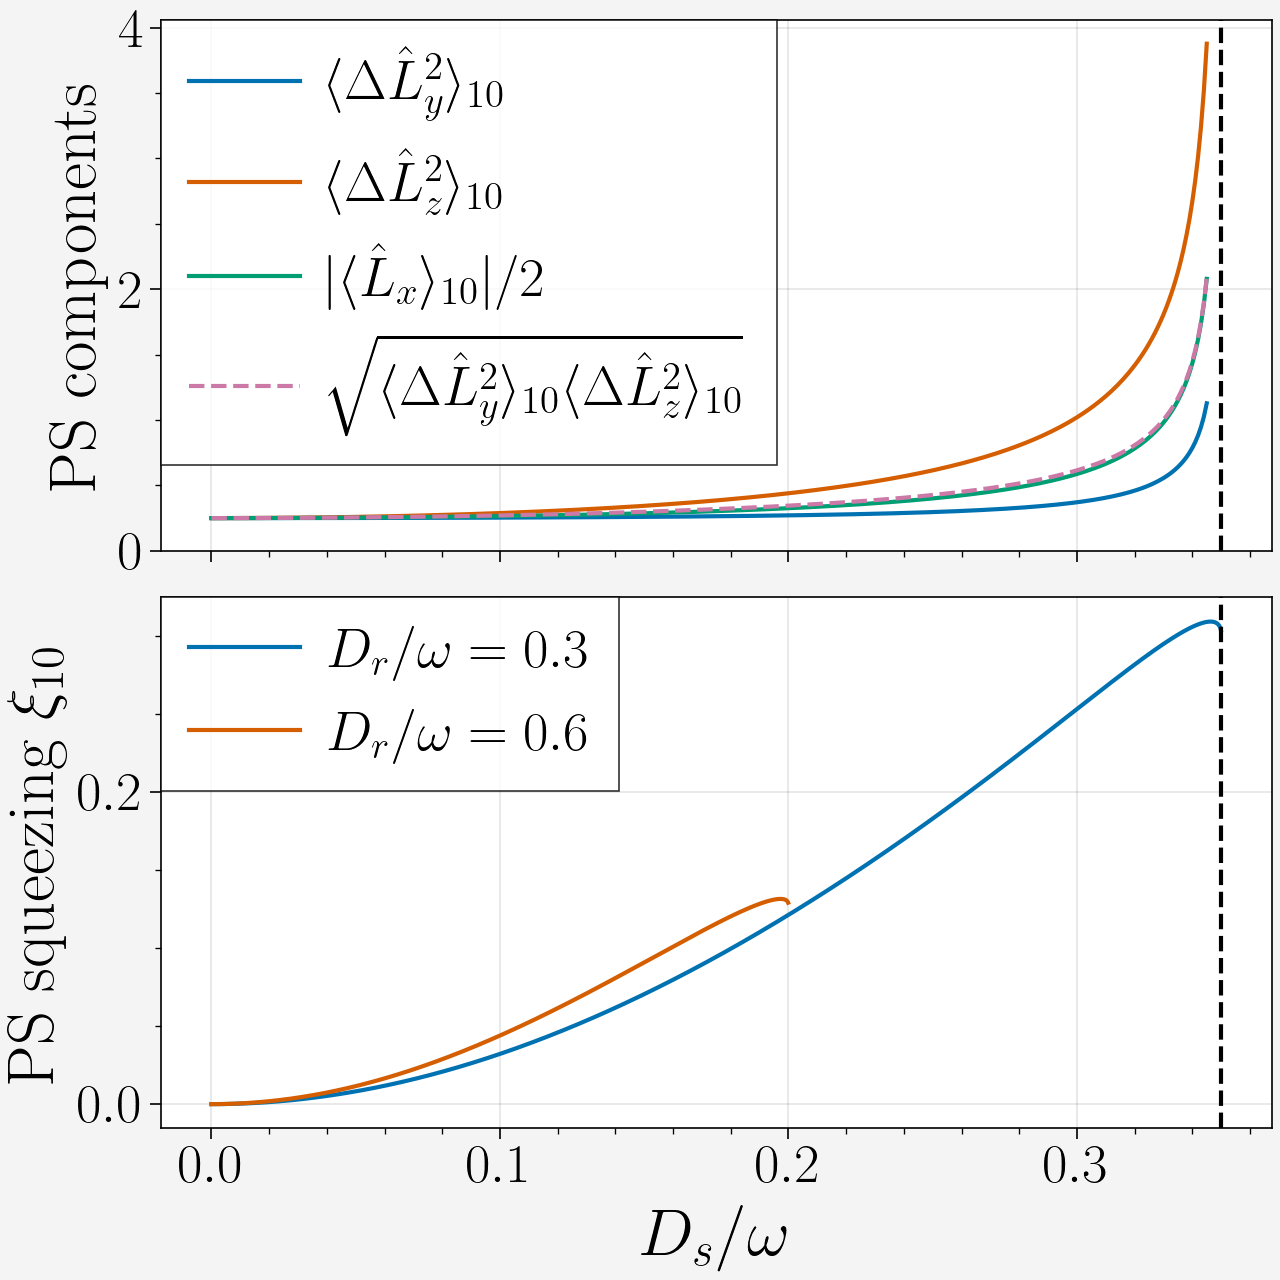

In [69]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6.4,6.4), sharex = True, constrained_layout = True)

Dr = 0.3

x = np.arange(0,0.346,0.001)
m,n = 1,0
VarY = varLy_mn(x, Dr, m,n)
X = np.abs(Lx_mn(x, Dr, m,n))
VarZ = varLz_mn(x, Dr, m,n)

ax0.plot(x, VarY, label = r'$\langle \Delta \hat{L}_y^2\rangle_{10}$')#wd_label[i])
ax0.plot(x, VarZ, label = r'$\langle \Delta \hat{L}_z^2 \rangle_{10}$')#wd_label[i])
ax0.plot(x, X/2, label = r'$|\langle \hat{L}_x\rangle_{10}|$/2')#wd_label[i])
ax0.plot(x, np.sqrt(VarY*VarZ), label = r'$\sqrt{\langle \Delta \hat{L}_y^2\rangle_{10}\langle \Delta \hat{L}_z^2\rangle_{10}}$', linestyle = '--')#wd_label[i])
#ax.plot(x,2*VarY/X)

#ax0.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax0.set_ylabel(r'PS components', fontsize = 24)
ax0.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
#ax.set_title('$\chi = 0$', fontsize = 28)
ax0.axvline(0.35, linestyle = '--', color = 'black')
ax0.legend(fontsize=20)
ax0.set_yticks([0,2,4])
x = np.arange(0.0,0.5,0.0001)
m,n = 1,0

Dr = 0.3
ax1.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$')

Dr = 0.6
ax1.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.6$')

ax1.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax1.set_ylabel(r'PS squeezing $\xi_{10}$', fontsize = 24)
ax1.tick_params(labelsize = 20) 
ax1.set_yticks([0,0.2])
plt.legend(fontsize=20)
plt.axvline(0.35, linestyle = '--', color = 'black')
plt.savefig('fig2.svg')
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/1714860473.py:7: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, -1/4*np.log(2*varLy_mn(x, Dr, m,n)/Lx_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$', color = 'tab:orange')
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/74294631.py:5: RuntimeWarning: invalid value encountered in subtract
  varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2
C:\Users\anlur\AppData\Local\Temp/ipykernel_6824/4177641686.py:4: RuntimeWarning: invalid value encountered 

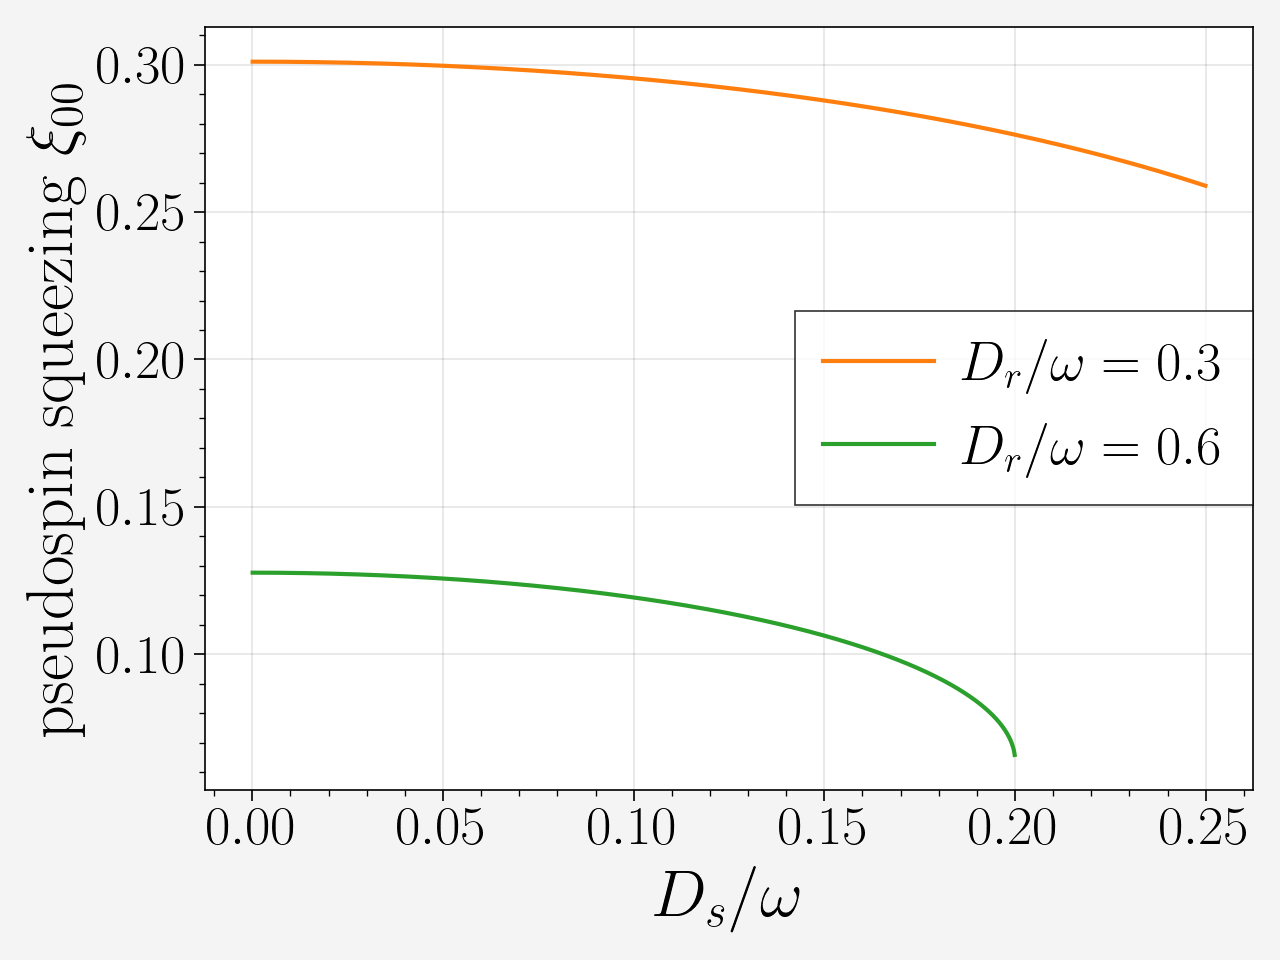

In [32]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

x = np.arange(0.0,0.25,0.0001)
m,n = 0,0

Dr = 0.3
ax.plot(x, -1/4*np.log(2*varLy_mn(x, Dr, m,n)/Lx_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$', color = 'tab:orange')

Dr = 0.6
ax.plot(x, -1/4*np.log(2*varLy_mn(x, Dr, m,n)/Lx_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.6$', color = 'tab:green')

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin squeezing $\xi_{00}$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.05,0.1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.savefig('fig2c.jpg')
plt.show()

## Fig3

Notes:
- $r_1$ is only defined for $D/\omega < \exp(-2r)/2$ or $D/\omega > \exp(2r)/2$ and $\chi/\omega < \sqrt{1 - 4D\cosh(2r)/\omega+ (D/\omega)^2}$

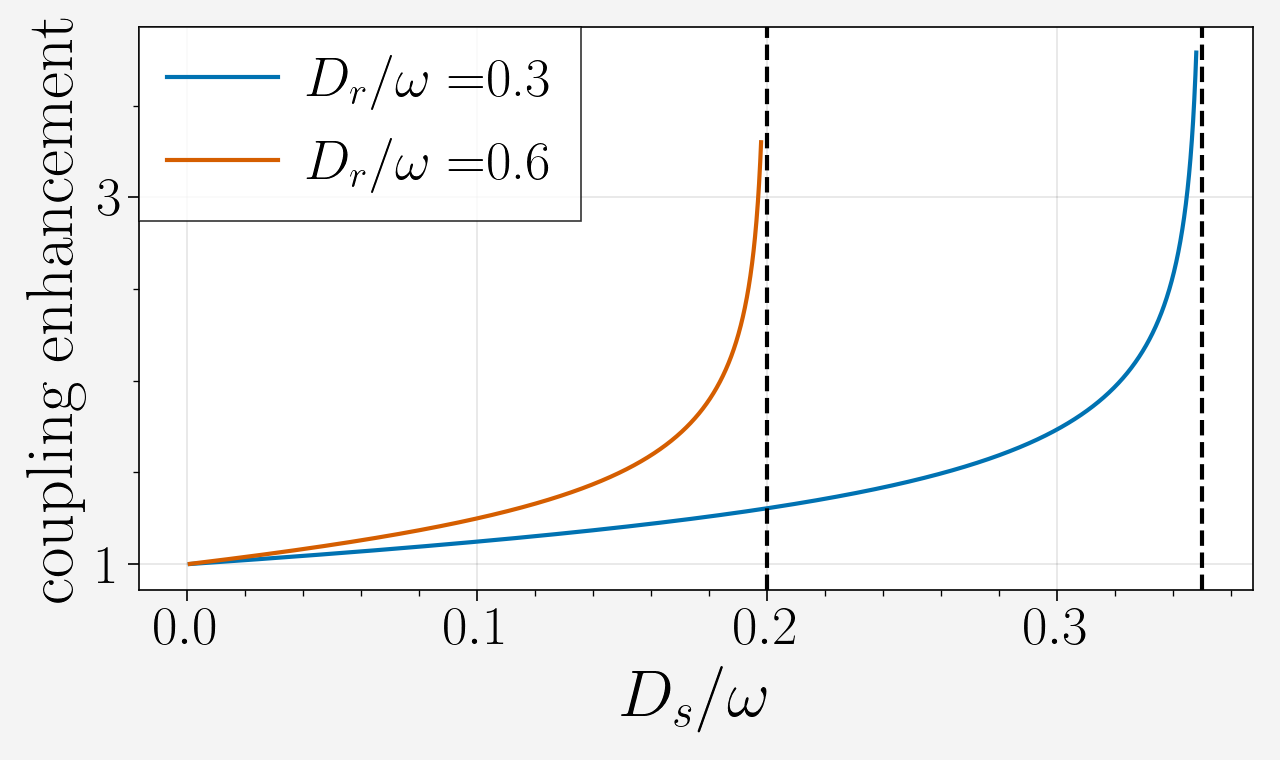

In [74]:
fig, ax = plt.subplots(figsize=(6.4,3.8), tight_layout = 'True')

r = 1
chi = 0

Dr=0.3
x = np.arange(0.001,0.348,0.0001)
r1 = r1g(x, Dr, chi)
ax.plot(x, np.cosh(r+r1)/np.cosh(r), label = '{}{}'.format(r'$D_r/\omega=$',Dr))#wd_label[i])
plt.axvline(0.35, linestyle = '--', color = 'black')

Dr=0.6
x = np.arange(0.001,0.198,0.0001)
r1 = r1g(x, Dr, chi)
ax.plot(x, np.cosh(r+r1)/np.cosh(r), label = '{}{}'.format(r'$D_r/\omega=$',Dr))#wd_label[i])
plt.axvline(0.2, linestyle = '--', color = 'black')

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'coupling enhancement', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.05,0.1])
#ax.set_ylim(0.9, 7)
ax.set_yticks([1,3])
plt.legend(fontsize=20)
plt.savefig('fig3b.svg')
plt.show()

## Fig4

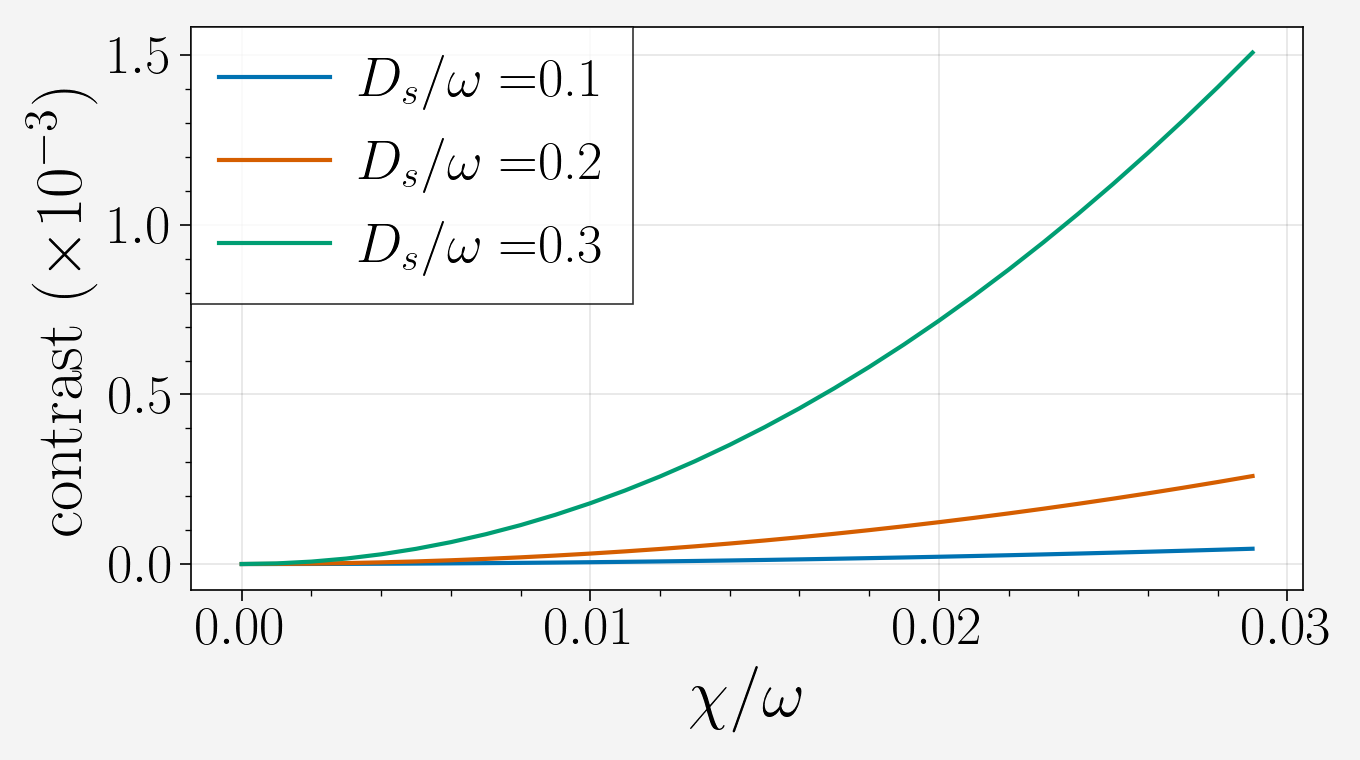

In [76]:
fig, ax = plt.subplots(figsize=(6.8,3.8), tight_layout = 'True')

x = np.arange(0,0.03,0.001)

Dr = 0.3
Ds_arr = [0.1, 0.2,0.3]

for Ds in Ds_arr:
    r1 = r1g(Ds, Dr, 0)
    r2 = r2g(Ds, Dr, 0)
    c = x**2*np.sinh(r1-r2)**2/Dr**2
    ax.plot(x, c*1000, label = '{}{}'.format(r'$D_s/\omega=$',Ds))#wd_label[i])

ax.set_xlabel(r'$\chi/\omega$', fontsize = 24)
ax.set_ylabel(r'contrast ($\times10^{-3}$)', fontsize = 24)
ax.tick_params(labelsize = 20) 
plt.legend(fontsize=20)
plt.savefig('fig4.svg')
plt.show()

## SM

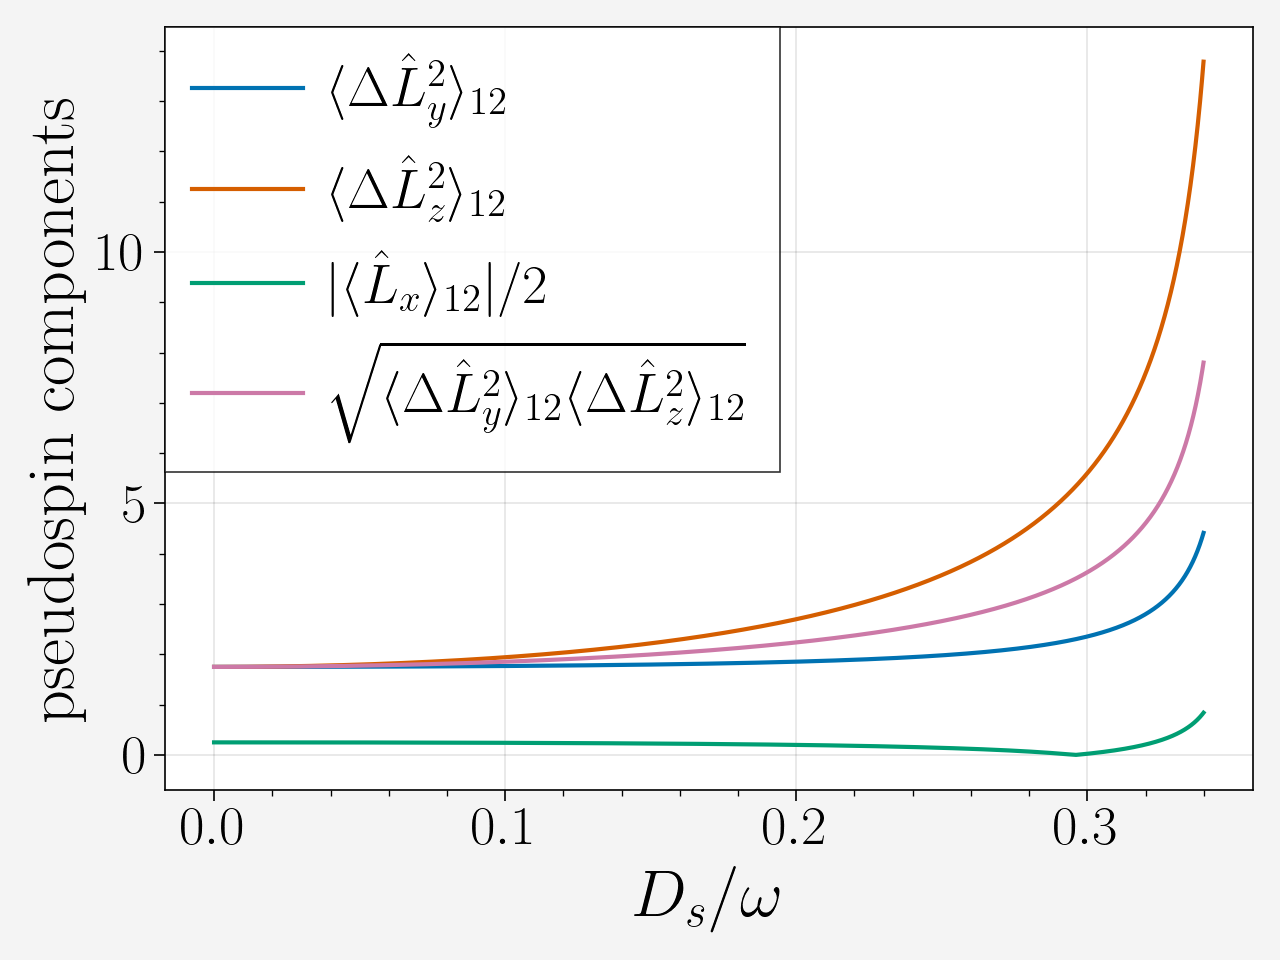

In [29]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

Dr = 0.3

x = np.arange(0,0.34,0.0001)
m,n = 1,2
VarY = varLy_mn(x, Dr, m,n)
X = np.abs(Lx_mn(x, Dr, m,n))
VarZ = varLz_mn(x, Dr, m,n)

ax.plot(x, VarY, label = r'$\langle \Delta \hat{L}_y^2\rangle_{12}$')#wd_label[i])
ax.plot(x, VarZ, label = r'$\langle \Delta \hat{L}_z^2 \rangle_{12}$')#wd_label[i])
ax.plot(x, X/2, label = r'$|\langle \hat{L}_x\rangle_{12}|$/2')#wd_label[i])
ax.plot(x, np.sqrt(VarY*VarZ), label = r'$\sqrt{\langle \Delta \hat{L}_y^2\rangle_{12}\langle \Delta \hat{L}_z^2\rangle_{12}}$')#wd_label[i])
#ax.plot(x,2*VarY/X)

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin components', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.5,1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.savefig('fig_sm1.jpg')
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/74294631.py:5: RuntimeWarning: invalid value encountered in subtract
  varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2


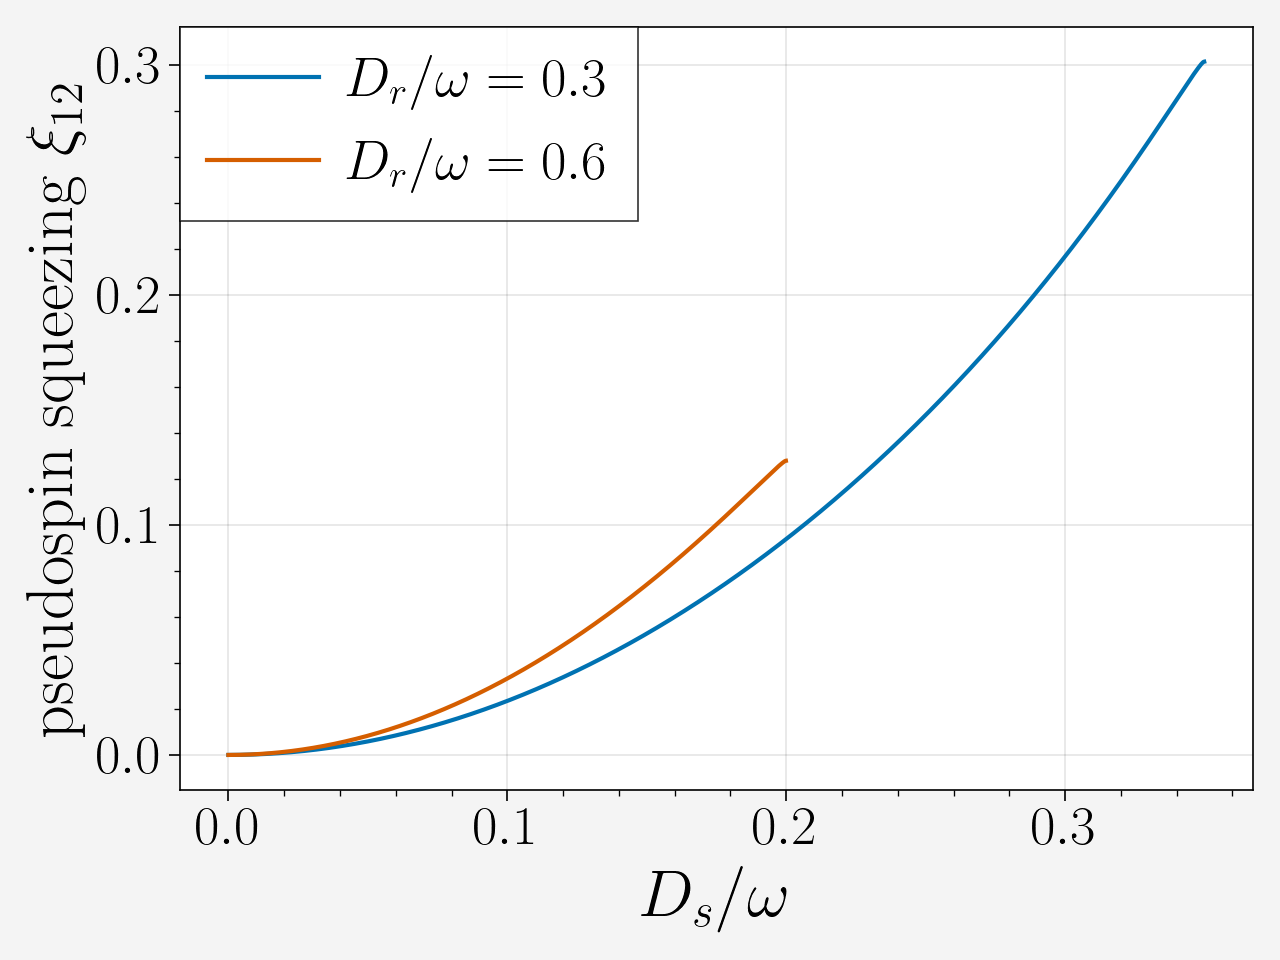

In [27]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

x = np.arange(0.0,0.5,0.0001)
m,n = 1,2
Dr = 0.0
#ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.0$')

Dr = 0.3
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$')

Dr = 0.6
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.6$')

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin squeezing $\xi_{12}$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.05,0.1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.savefig('fig_sm2.jpg')
plt.show()

C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/1470849234.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$')
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: divide by zero encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/3989565086.py:4: RuntimeWarning: invalid value encountered in arctanh
  r1g = np.arctanh(2*Ds_inp/(1 - wg/2))/2
C:\Users\anlur\AppData\Local\Temp/ipykernel_9412/74294631.py:5: RuntimeWarning: invalid value encountered in subtract
  varLy = 1/4*(2*m_inp*n_inp+m_inp+n_inp)*((np.cosh(r1)*np.cosh(r2)-np.sinh(r1)*np.sinh(r2))**2+(np.sinh(r1)*np.cosh(r2)-np.sinh(r2)*np.cosh(r1))**2) + 1/4*(np.sinh(r1)*np.cosh(

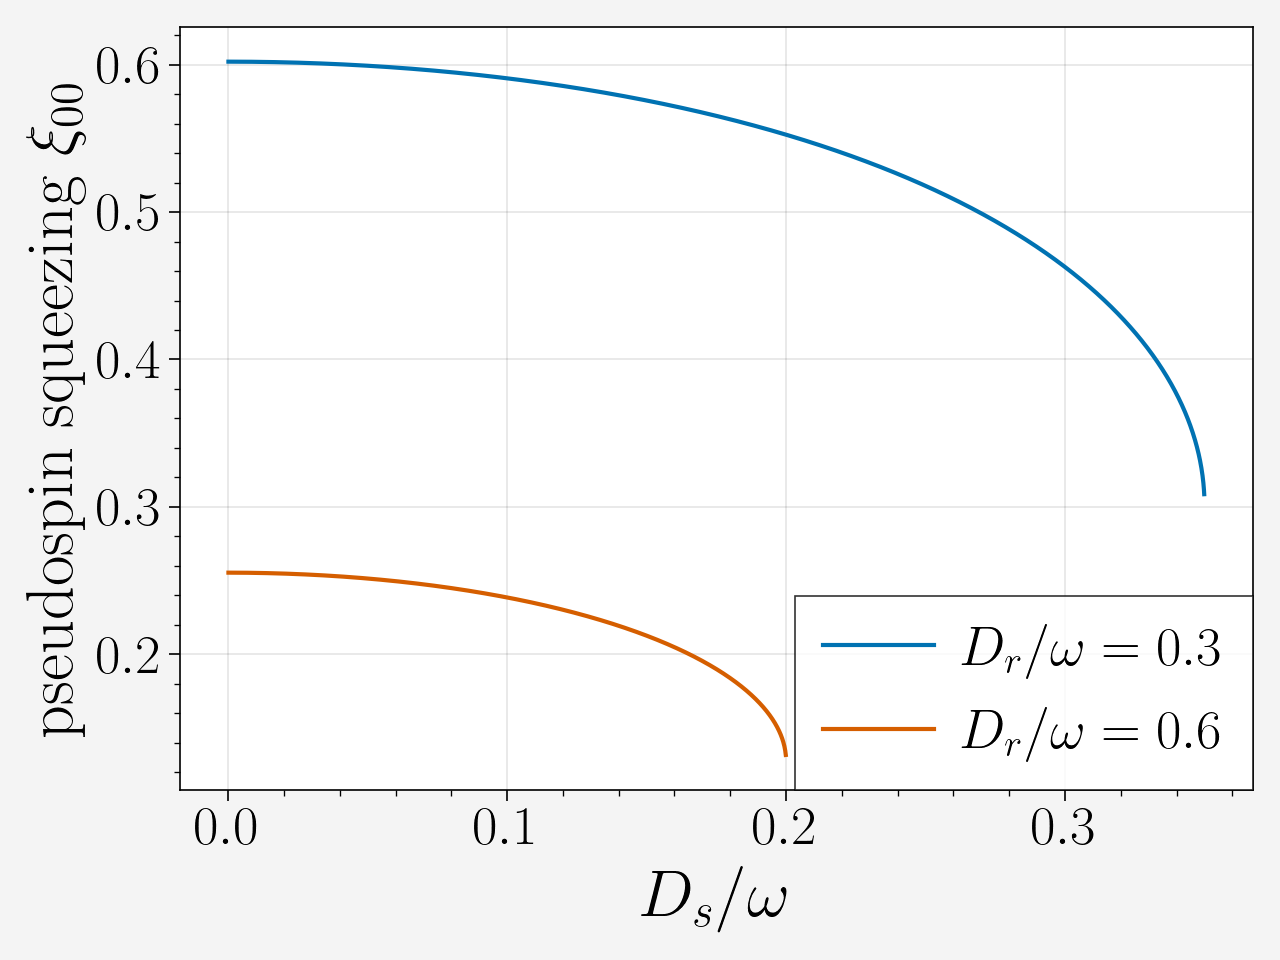

In [28]:
fig, ax = plt.subplots(figsize=(6.4,4.8), tight_layout = 'True')

x = np.arange(0.0,0.5,0.0001)
m,n = 0,0
Dr = 0.0
#ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.0$')

Dr = 0.3
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.3$')

Dr = 0.6
ax.plot(x, -1/4*np.log(varLy_mn(x, Dr, m,n)/varLz_mn(x, Dr, m,n)), label = r'$D_r/\omega=0.6$')

ax.set_xlabel(r'$D_s/\omega$', fontsize = 24)
ax.set_ylabel(r'pseudospin squeezing $\xi_{00}$', fontsize = 24)
ax.tick_params(labelsize = 20) 
#ax.set_yticks([0,0.05,0.1])
#ax.set_title('$\chi = 0$', fontsize = 28)
plt.legend(fontsize=20)
plt.savefig('fig_sm3.jpg')
plt.show()